# Feature engineering

Here we will use the knowladge from EDA and use only features that are in any sense correlated with the target

In [1]:
import numpy as np
import pandas as pd
from typing import List
from pandas.core.frame import DataFrame
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBClassifier
from feature_engine.encoding import OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from feature_engine.imputation import MeanMedianImputer
from feature_engine.wrappers import SklearnTransformerWrapper
from feature_engine.selection import  RecursiveFeatureElimination
from feature_engine.selection import DropHighPSIFeatures
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from feature_engine.selection import SelectBySingleFeaturePerformance
from feature_engine.imputation import CategoricalImputer
from feature_engine.selection import DropHighPSIFeatures
from feature_engine.encoding import RareLabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')
pd.options.display.max_columns = None
pd.options.display.max_rows = None

pd.options.display.width = None
pd.options.display.max_colwidth = None
pd.options.display.float_format = '{:,.2f}'.format

In [2]:

def reduce_memory_usage(df: DataFrame) -> DataFrame:
    """Reduced memory usage by downcasting datatype of columns.
    Input: DataFrame
    Output: DataFrame"""

    for column in df:
        if df[column].dtype in ["float64", "float32"]:
             df[column]=pd.to_numeric(df[column], downcast="float")
        if df[column].dtype in ["int64", "int32"]:
            df[column]=pd.to_numeric(df[column], downcast="integer")
    return df

def load_data(name: str) -> DataFrame:

    """Loads DataFrame from csv and reduces used memory.
    Parameters: name (the name of csv file without .csv extension)
    Returns: DataFrame"""
    
    print('-'*100)
    print(f'{name}.csv loading')
    df = pd.read_csv(f'{name}.csv')
    memory = df.memory_usage().sum() / 1024**2
    df = reduce_memory_usage(df)
    print(f'memory usage reduced from {memory:.1f}MB to {(df.memory_usage().sum() / 1024**2):.1f}MB')
    print('-'*100)
    return df


def organization_replacer(value: any) -> any:
    """Reduces the number of unique values 
    where there are subcategories with ':' sign"""
    
    if value not in [np.nan, None]:
        x = value.split()[0]
        if x[-1] ==":":
            return x[:-1]
        elif x == "Business":
            return "Business"
    return value

def yes_no_replacer(value: str) -> int:
    """Encodes yes, no columns to 0 and 1"""
    if value is ['Y', 'Yes']:
        return 1
    elif value in ['N', 'No']:
        return 0

def reduce_cardinality(df, threshold=0.01):
    """Reduces the cardinality of a DataFrame by grouping low-frequency values
    Parameters: DataFrame, threshold (threshold of normalized count of values as float)
    Returns: DataFrame with reduced cardinality"""

    for col in df.columns:
        if df[col].dtype == 'object':
            value_counts = df[col].value_counts(normalize=True)
            low_frequency_values = value_counts[value_counts < threshold].index.tolist()
            df[col] = df[col].apply(lambda x: 'Other' if x in low_frequency_values else x)
    return df

def days_replacer(value: float) -> float:
    if value not in [np.nan, None]:
        return round((value / -365), 2)

def pie_plot(df: DataFrame, col_name: str, labels: List) -> None:
    """Plots a pie chart of distribution of chosen column."""
    
    # Data to plot
    plot_data = df[col_name].value_counts() / df.shape[0]
    
    # Pie plot
    plt.title(f"Pie chart of {col_name} variable")
    plt.pie(plot_data, labels=labels, labeldistance=1.15, 
            wedgeprops= { 'linewidth' : 3, 'edgecolor' : 'white' }, autopct='%1.1f%%')

In [3]:
for name in ['application_train', 'bureau', 'bureau_balance', 'credit_card_balance', 'installments_payments', 'POS_CASH_balance', 'previous_application']:
    globals()[name] = load_data(name)

----------------------------------------------------------------------------------------------------
application_train.csv loading
memory usage reduced from 286.2MB to 129.3MB
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bureau.csv loading
memory usage reduced from 222.6MB to 158.8MB
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
bureau_balance.csv loading
memory usage reduced from 624.8MB to 338.5MB
----------------------------------------------------------------------------------------------------
----------------------------------------------------------------------------------------------------
credit_card_balance.csv loading
memory usage reduced from 673.9MB to 479.8MB
-----

In [3]:
# Aggreagating with target variable
application_train = reduce_memory_usage(pd.read_csv('application_train.csv')).loc[:, ['SK_ID_CURR', 'TARGET']]

## Preprocess bureau and bureau_balance

Preprocessing bureau_balance:
* encode the status
* sort in ascending order by id and balance
* calculating weighted status
* calculating how many years back the credit was taken
* aggregating features from fresh and old credit history (last 2 years and above)

In [40]:
bureau = reduce_memory_usage(pd.read_csv('bureau.csv'))
bureau_balance = reduce_memory_usage(pd.read_csv('bureau_balance.csv'))
application_train = reduce_memory_usage(pd.read_csv('application_train.csv'))

In [41]:
# Encoding status 
dict_for_status = { 'C': 1, '0': 2, '1': 3, '2': 4, 'X': 5, '3': 6, '4': 7, '5': 8}
bureau_balance['STATUS'] = bureau_balance['STATUS'].map(dict_for_status)

# Sort in ascending order
bureau_balance = bureau_balance.sort_values(by=['SK_ID_BUREAU', 'MONTHS_BALANCE'], ascending=[0,0])

# Change sign of month
bureau_balance['MONTHS_BALANCE'] = bureau_balance['MONTHS_BALANCE'].apply(lambda x : -x)

# Calculate weighted status
bureau_balance['WEIGHTED_STATUS'] = bureau_balance['STATUS'] / (bureau_balance['MONTHS_BALANCE'] + 1)

# Calculate years
bureau_balance['YEARS_BALANCE'] = bureau_balance['MONTHS_BALANCE'] // 12

In [43]:
# Calculating aggreagations from last 2 years
fresh_bureau_balance = bureau_balance.loc[bureau_balance['YEARS_BALANCE'] <=2]

aggregations_fresh = {
    'MONTHS_BALANCE' : ['mean', 'min'],
    'STATUS': ['mean', 'max', 'first'],
    'WEIGHTED_STATUS': ['mean', 'std'] 
}

fresh_bureau_balance = fresh_bureau_balance.groupby(['SK_ID_BUREAU']).agg(aggregations_fresh)
fresh_bureau_balance.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_bureau_balance.columns]

fresh_bureau_balance.head()

,FRESH_MONTHS_BALANCE_MEAN,FRESH_MONTHS_BALANCE_MIN,FRESH_STATUS_MEAN,FRESH_STATUS_MAX,FRESH_STATUS_FIRST,FRESH_WEIGHTED_STATUS_MEAN,FRESH_WEIGHTED_STATUS_STD
SK_ID_BUREAU,,,,,,,
5001709,17.50,0,1.00,1,1,0.12,0.18
5001710,17.50,0,1.00,1,1,0.12,0.18
5001711,1.50,0,2.75,5,5,1.79,2.15
5001712,9.00,0,1.53,2,1,0.22,0.21
5001713,10.50,0,5.00,5,5,0.84,1.08


In [44]:
old_balance_history = bureau_balance.loc[bureau_balance['YEARS_BALANCE'] > 2]
aggregations_old = {
    'MONTHS_BALANCE' : ['mean', 'max'],
    'STATUS': ['mean', 'max', 'count'],
    'WEIGHTED_STATUS': ['mean', 'std'] 
}
old_bureau_balance = old_balance_history.groupby(['SK_ID_BUREAU']).agg(aggregations_old)
old_bureau_balance.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_bureau_balance.columns]
old_bureau_balance.head()

,OLD_MONTHS_BALANCE_MEAN,OLD_MONTHS_BALANCE_MAX,OLD_STATUS_MEAN,OLD_STATUS_MAX,OLD_STATUS_COUNT,OLD_WEIGHTED_STATUS_MEAN,OLD_WEIGHTED_STATUS_STD
SK_ID_BUREAU,,,,,,,
5001709,66.00,96,1.72,5,61,0.02,0.01
5001710,59.00,82,3.66,5,47,0.06,0.02
5001715,47.50,59,5.00,5,24,0.11,0.02
5001716,60.50,85,3.14,5,50,0.05,0.02
5001718,37.00,38,3.00,5,3,0.08,0.04


In [45]:
# Merging old and fresh balance 
agg_bureau_balance = old_bureau_balance.merge(fresh_bureau_balance, right_index=True, left_index=True, how='outer')

In [46]:
agg_bureau_balance.fillna(0, inplace=True)
agg_bureau_balance.head()

,OLD_MONTHS_BALANCE_MEAN,OLD_MONTHS_BALANCE_MAX,OLD_STATUS_MEAN,OLD_STATUS_MAX,OLD_STATUS_COUNT,OLD_WEIGHTED_STATUS_MEAN,OLD_WEIGHTED_STATUS_STD,FRESH_MONTHS_BALANCE_MEAN,FRESH_MONTHS_BALANCE_MIN,FRESH_STATUS_MEAN,FRESH_STATUS_MAX,FRESH_STATUS_FIRST,FRESH_WEIGHTED_STATUS_MEAN,FRESH_WEIGHTED_STATUS_STD
SK_ID_BUREAU,,,,,,,,,,,,,,
5001709,66.00,96.00,1.72,5.00,61.00,0.02,0.01,17.50,0.00,1.00,1.00,1.00,0.12,0.18
5001710,59.00,82.00,3.66,5.00,47.00,0.06,0.02,17.50,0.00,1.00,1.00,1.00,0.12,0.18
5001711,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.50,0.00,2.75,5.00,5.00,1.79,2.15
5001712,0.00,0.00,0.00,0.00,0.00,0.00,0.00,9.00,0.00,1.53,2.00,1.00,0.22,0.21
5001713,0.00,0.00,0.00,0.00,0.00,0.00,0.00,10.50,0.00,5.00,5.00,5.00,0.84,1.08


In [47]:
agg_bureau_balance = reduce_memory_usage(agg_bureau_balance.reset_index())

In [48]:
agg_bureau_balance.to_csv("preprocessed_data/agg_bureau_balance.csv")

In [49]:
del bureau_balance

Preprocessing of bureau.csv:
* merging with aggregated bureau_balance
* replacing nonsense data based on eda we will replace any value with credits over 50 years with NaN
* engineering and aggregating features

In [12]:
agg_bureau_balance = reduce_memory_usage(pd.read_csv("preprocessed_data/agg_bureau_balance.csv"))
bureau = reduce_memory_usage(pd.read_csv('bureau.csv'))
application_train = reduce_memory_usage(pd.read_csv('application_train.csv'))

In [76]:
bureau.head()

,SK_ID_CURR,SK_ID_BUREAU,CREDIT_ACTIVE,CREDIT_CURRENCY,DAYS_CREDIT,CREDIT_DAY_OVERDUE,DAYS_CREDIT_ENDDATE,DAYS_ENDDATE_FACT,AMT_CREDIT_MAX_OVERDUE,CNT_CREDIT_PROLONG,AMT_CREDIT_SUM,AMT_CREDIT_SUM_DEBT,AMT_CREDIT_SUM_LIMIT,AMT_CREDIT_SUM_OVERDUE,CREDIT_TYPE,DAYS_CREDIT_UPDATE,AMT_ANNUITY
0,215354,5714462,Closed,currency 1,-497,0,-153.00,-153.00,NaN,0,"91,323.00",0.00,NaN,0.00,Consumer credit,-131,NaN
1,215354,5714463,Active,currency 1,-208,0,"1,075.00",NaN,NaN,0,"225,000.00","171,342.00",NaN,0.00,Credit card,-20,NaN
2,215354,5714464,Active,currency 1,-203,0,528.00,NaN,NaN,0,"464,323.50",NaN,NaN,0.00,Consumer credit,-16,NaN
3,215354,5714465,Active,currency 1,-203,0,NaN,NaN,NaN,0,"90,000.00",NaN,NaN,0.00,Credit card,-16,NaN
4,215354,5714466,Active,currency 1,-629,0,"1,197.00",NaN,"77,674.50",0,"2,700,000.00",NaN,NaN,0.00,Consumer credit,-21,NaN


In [50]:
# Merging with agg_bureau_balance
bureau_merged = bureau.merge(agg_bureau_balance, on = 'SK_ID_BUREAU', how='left')


In [51]:
# Cleaning data from nonsense values
columns_to_replace = ['DAYS_CREDIT_ENDDATE', 'DAYS_ENDDATE_FACT', 'DAYS_CREDIT_UPDATE']
bureau_merged[columns_to_replace] = bureau_merged[columns_to_replace].apply(lambda x: np.where(x > -50*365, np.nan, x))

In [19]:
bureau_merged.CREDIT_ACTIVE.unique()

array(['Closed', 'Active', 'Sold', 'Bad debt'], dtype=object)

In [52]:

bureau_merged['DAYS_ENDDATE_FACT'].fillna(0, inplace=True)


In [54]:
# Feature engineering
bureau_merged['RATIO_OF_PAID_AMT'] = bureau_merged['AMT_CREDIT_SUM_DEBT'] / bureau_merged['AMT_CREDIT_SUM']

In [56]:
bureau_merged.columns
bureau_merged.drop('SK_ID_BUREAU', axis=1, inplace=True)

In [57]:
agg_bureau = bureau_merged.groupby(['SK_ID_CURR', 'CREDIT_ACTIVE']).agg(['min', 'max', 'mean'])
agg_bureau.columns = ['_'.join(ele).upper() for ele in agg_bureau.columns]
agg_bureau.reset_index(inplace=True)
agg_bureau.head()

,SK_ID_CURR,CREDIT_ACTIVE,DAYS_CREDIT_MIN,DAYS_CREDIT_MAX,DAYS_CREDIT_MEAN,CREDIT_DAY_OVERDUE_MIN,CREDIT_DAY_OVERDUE_MAX,CREDIT_DAY_OVERDUE_MEAN,DAYS_CREDIT_ENDDATE_MIN,DAYS_CREDIT_ENDDATE_MAX,DAYS_CREDIT_ENDDATE_MEAN,DAYS_ENDDATE_FACT_MIN,DAYS_ENDDATE_FACT_MAX,DAYS_ENDDATE_FACT_MEAN,AMT_CREDIT_MAX_OVERDUE_MIN,AMT_CREDIT_MAX_OVERDUE_MAX,AMT_CREDIT_MAX_OVERDUE_MEAN,CNT_CREDIT_PROLONG_MIN,CNT_CREDIT_PROLONG_MAX,CNT_CREDIT_PROLONG_MEAN,AMT_CREDIT_SUM_MIN,AMT_CREDIT_SUM_MAX,AMT_CREDIT_SUM_MEAN,AMT_CREDIT_SUM_DEBT_MIN,AMT_CREDIT_SUM_DEBT_MAX,AMT_CREDIT_SUM_DEBT_MEAN,AMT_CREDIT_SUM_LIMIT_MIN,AMT_CREDIT_SUM_LIMIT_MAX,AMT_CREDIT_SUM_LIMIT_MEAN,AMT_CREDIT_SUM_OVERDUE_MIN,AMT_CREDIT_SUM_OVERDUE_MAX,AMT_CREDIT_SUM_OVERDUE_MEAN,DAYS_CREDIT_UPDATE_MIN,DAYS_CREDIT_UPDATE_MAX,DAYS_CREDIT_UPDATE_MEAN,AMT_ANNUITY_MIN,AMT_ANNUITY_MAX,AMT_ANNUITY_MEAN,OLD_MONTHS_BALANCE_MEAN_MIN,OLD_MONTHS_BALANCE_MEAN_MAX,OLD_MONTHS_BALANCE_MEAN_MEAN,OLD_MONTHS_BALANCE_MAX_MIN,OLD_MONTHS_BALANCE_MAX_MAX,OLD_MONTHS_BALANCE_MAX_MEAN,OLD_STATUS_MEAN_MIN,OLD_STATUS_MEAN_MAX,OLD_STATUS_MEAN_MEAN,OLD_STATUS_MAX_MIN,OLD_STATUS_MAX_MAX,OLD_STATUS_MAX_MEAN,OLD_STATUS_COUNT_MIN,OLD_STATUS_COUNT_MAX,OLD_STATUS_COUNT_MEAN,OLD_WEIGHTED_STATUS_MEAN_MIN,OLD_WEIGHTED_STATUS_MEAN_MAX,OLD_WEIGHTED_STATUS_MEAN_MEAN,OLD_WEIGHTED_STATUS_STD_MIN,OLD_WEIGHTED_STATUS_STD_MAX,OLD_WEIGHTED_STATUS_STD_MEAN,FRESH_MONTHS_BALANCE_MEAN_MIN,FRESH_MONTHS_BALANCE_MEAN_MAX,FRESH_MONTHS_BALANCE_MEAN_MEAN,FRESH_MONTHS_BALANCE_MIN_MIN,FRESH_MONTHS_BALANCE_MIN_MAX,FRESH_MONTHS_BALANCE_MIN_MEAN,FRESH_STATUS_MEAN_MIN,FRESH_STATUS_MEAN_MAX,FRESH_STATUS_MEAN_MEAN,FRESH_STATUS_MAX_MIN,FRESH_STATUS_MAX_MAX,FRESH_STATUS_MAX_MEAN,FRESH_STATUS_FIRST_MIN,FRESH_STATUS_FIRST_MAX,FRESH_STATUS_FIRST_MEAN,FRESH_WEIGHTED_STATUS_MEAN_MIN,FRESH_WEIGHTED_STATUS_MEAN_MAX,FRESH_WEIGHTED_STATUS_MEAN_MEAN,FRESH_WEIGHTED_STATUS_STD_MIN,FRESH_WEIGHTED_STATUS_STD_MAX,FRESH_WEIGHTED_STATUS_STD_MEAN,RATIO_OF_PAID_AMT_MIN,RATIO_OF_PAID_AMT_MAX,RATIO_OF_PAID_AMT_MEAN
0,100001,Active,-559,-49,-309.33,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,0,0,0.00,"168,345.00","378,000.00","294,675.00","110,281.50","373,239.00","198,895.50",0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,"4,630.50","10,822.50","8,272.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,9.00,4.83,0.00,0.00,0.00,2.00,3.50,2.83,2.00,5.00,4.00,2.00,3.00,2.33,0.51,2.25,1.10,0.35,0.65,0.51,0.34,0.99,0.66
1,100001,Closed,-1572,-857,"-1,054.25",0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,0,0,0.00,"85,500.00","279,720.00","142,335.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,43.50,10.88,0.00,51.00,12.75,0.00,2.81,0.70,0.00,5.00,1.25,0.00,16.00,4.00,0.00,0.06,0.02,0.00,0.04,0.01,14.00,17.50,15.00,0.00,0.00,0.00,1.00,2.31,1.60,1.00,5.00,3.25,1.00,1.00,1.00,0.12,0.19,0.16,0.18,0.19,0.19,0.00,0.00,0.00
2,100002,Active,-1042,-103,-572.50,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,40.50,40.50,40.50,0,0,0.00,"31,988.56","450,000.00","240,994.28",0.00,"245,781.00","122,890.50",0.00,"31,988.56","15,994.28",0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.50,26.50,14.00,0.00,19.00,9.50,2.81,3.50,3.16,5.00,5.00,5.00,1.00,2.00,1.50,0.10,1.48,0.79,0.04,0.44,0.24,0.00,0.55,0.27
3,100002,Closed,-1437,-476,-974.50,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,"5,043.65","2,091.16",0,0,0.00,0.00,"135,000.00","63,844.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,41.50,18.92,0.00,47.00,19.83,0.00,5.00,2.18,0.00,5.00,2.50,0.00,12.00,2.33,0.00,0.14,0.06,0.00,0.03,0.00,7.50,33.50,23.33,0.00,32.00,17.50,1.19,2.81,2.19,2.00,5.00,3.50,1.00,2.00,1.17,0.06,0.22,0.11,0.02,0.23,0.07,0.00,0.00,0.00
4,100003,Active,-606,-606,-606.00,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,"810,000.00","810,000.00","810,000.00",0.00,0.00,0.00,"810,000.00","810,000.00","810,000.

In [59]:
active = agg_bureau.loc[agg_bureau['CREDIT_ACTIVE']=='Active']
active.columns = [f"{ele}_ACTIVE" for ele in active.columns]
active.drop('CREDIT_ACTIVE_ACTIVE', axis=1, inplace=True)
active.head()

,SK_ID_CURR_ACTIVE,DAYS_CREDIT_MIN_ACTIVE,DAYS_CREDIT_MAX_ACTIVE,DAYS_CREDIT_MEAN_ACTIVE,CREDIT_DAY_OVERDUE_MIN_ACTIVE,CREDIT_DAY_OVERDUE_MAX_ACTIVE,CREDIT_DAY_OVERDUE_MEAN_ACTIVE,DAYS_CREDIT_ENDDATE_MIN_ACTIVE,DAYS_CREDIT_ENDDATE_MAX_ACTIVE,DAYS_CREDIT_ENDDATE_MEAN_ACTIVE,DAYS_ENDDATE_FACT_MIN_ACTIVE,DAYS_ENDDATE_FACT_MAX_ACTIVE,DAYS_ENDDATE_FACT_MEAN_ACTIVE,AMT_CREDIT_MAX_OVERDUE_MIN_ACTIVE,AMT_CREDIT_MAX_OVERDUE_MAX_ACTIVE,AMT_CREDIT_MAX_OVERDUE_MEAN_ACTIVE,CNT_CREDIT_PROLONG_MIN_ACTIVE,CNT_CREDIT_PROLONG_MAX_ACTIVE,CNT_CREDIT_PROLONG_MEAN_ACTIVE,AMT_CREDIT_SUM_MIN_ACTIVE,AMT_CREDIT_SUM_MAX_ACTIVE,AMT_CREDIT_SUM_MEAN_ACTIVE,AMT_CREDIT_SUM_DEBT_MIN_ACTIVE,AMT_CREDIT_SUM_DEBT_MAX_ACTIVE,AMT_CREDIT_SUM_DEBT_MEAN_ACTIVE,AMT_CREDIT_SUM_LIMIT_MIN_ACTIVE,AMT_CREDIT_SUM_LIMIT_MAX_ACTIVE,AMT_CREDIT_SUM_LIMIT_MEAN_ACTIVE,AMT_CREDIT_SUM_OVERDUE_MIN_ACTIVE,AMT_CREDIT_SUM_OVERDUE_MAX_ACTIVE,AMT_CREDIT_SUM_OVERDUE_MEAN_ACTIVE,DAYS_CREDIT_UPDATE_MIN_ACTIVE,DAYS_CREDIT_UPDATE_MAX_ACTIVE,DAYS_CREDIT_UPDATE_MEAN_ACTIVE,AMT_ANNUITY_MIN_ACTIVE,AMT_ANNUITY_MAX_ACTIVE,AMT_ANNUITY_MEAN_ACTIVE,OLD_MONTHS_BALANCE_MEAN_MIN_ACTIVE,OLD_MONTHS_BALANCE_MEAN_MAX_ACTIVE,OLD_MONTHS_BALANCE_MEAN_MEAN_ACTIVE,OLD_MONTHS_BALANCE_MAX_MIN_ACTIVE,OLD_MONTHS_BALANCE_MAX_MAX_ACTIVE,OLD_MONTHS_BALANCE_MAX_MEAN_ACTIVE,OLD_STATUS_MEAN_MIN_ACTIVE,OLD_STATUS_MEAN_MAX_ACTIVE,OLD_STATUS_MEAN_MEAN_ACTIVE,OLD_STATUS_MAX_MIN_ACTIVE,OLD_STATUS_MAX_MAX_ACTIVE,OLD_STATUS_MAX_MEAN_ACTIVE,OLD_STATUS_COUNT_MIN_ACTIVE,OLD_STATUS_COUNT_MAX_ACTIVE,OLD_STATUS_COUNT_MEAN_ACTIVE,OLD_WEIGHTED_STATUS_MEAN_MIN_ACTIVE,OLD_WEIGHTED_STATUS_MEAN_MAX_ACTIVE,OLD_WEIGHTED_STATUS_MEAN_MEAN_ACTIVE,OLD_WEIGHTED_STATUS_STD_MIN_ACTIVE,OLD_WEIGHTED_STATUS_STD_MAX_ACTIVE,OLD_WEIGHTED_STATUS_STD_MEAN_ACTIVE,FRESH_MONTHS_BALANCE_MEAN_MIN_ACTIVE,FRESH_MONTHS_BALANCE_MEAN_MAX_ACTIVE,FRESH_MONTHS_BALANCE_MEAN_MEAN_ACTIVE,FRESH_MONTHS_BALANCE_MIN_MIN_ACTIVE,FRESH_MONTHS_BALANCE_MIN_MAX_ACTIVE,FRESH_MONTHS_BALANCE_MIN_MEAN_ACTIVE,FRESH_STATUS_MEAN_MIN_ACTIVE,FRESH_STATUS_MEAN_MAX_ACTIVE,FRESH_STATUS_MEAN_MEAN_ACTIVE,FRESH_STATUS_MAX_MIN_ACTIVE,FRESH_STATUS_MAX_MAX_ACTIVE,FRESH_STATUS_MAX_MEAN_ACTIVE,FRESH_STATUS_FIRST_MIN_ACTIVE,FRESH_STATUS_FIRST_MAX_ACTIVE,FRESH_STATUS_FIRST_MEAN_ACTIVE,FRESH_WEIGHTED_STATUS_MEAN_MIN_ACTIVE,FRESH_WEIGHTED_STATUS_MEAN_MAX_ACTIVE,FRESH_WEIGHTED_STATUS_MEAN_MEAN_ACTIVE,FRESH_WEIGHTED_STATUS_STD_MIN_ACTIVE,FRESH_WEIGHTED_STATUS_STD_MAX_ACTIVE,FRESH_WEIGHTED_STATUS_STD_MEAN_ACTIVE,RATIO_OF_PAID_AMT_MIN_ACTIVE,RATIO_OF_PAID_AMT_MAX_ACTIVE,RATIO_OF_PAID_AMT_MEAN_ACTIVE
0,100001,-559,-49,-309.33,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,0,0,0.00,"168,345.00","378,000.00","294,675.00","110,281.50","373,239.00","198,895.50",0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,"4,630.50","10,822.50","8,272.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.50,9.00,4.83,0.00,0.00,0.00,2.00,3.50,2.83,2.00,5.00,4.00,2.00,3.00,2.33,0.51,2.25,1.10,0.35,0.65,0.51,0.34,0.99,0.66
2,100002,-1042,-103,-572.50,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,40.50,40.50,40.50,0,0,0.00,"31,988.56","450,000.00","240,994.28",0.00,"245,781.00","122,890.50",0.00,"31,988.56","15,994.28",0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.50,26.50,14.00,0.00,19.00,9.50,2.81,3.50,3.16,5.00,5.00,5.00,1.00,2.00,1.50,0.10,1.48,0.79,0.04,0.44,0.24,0.00,0.55,0.27
4,100003,-606,-606,-606.00,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,"810,000.00","810,000.00","810,000.00",0.00,0.00,0.00,"810,000.00","810,000.00","810,000.00",0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00
7,100005,-137,-62,-99.50,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,"29,826.00","568,800.00","299,31

In [60]:
closed = agg_bureau.loc[agg_bureau['CREDIT_ACTIVE']=='Closed']
closed.columns = [f"{ele}_CLOSED" for ele in closed.columns]
closed.drop('CREDIT_ACTIVE_CLOSED', axis=1, inplace=True)
closed.head()

,SK_ID_CURR_CLOSED,DAYS_CREDIT_MIN_CLOSED,DAYS_CREDIT_MAX_CLOSED,DAYS_CREDIT_MEAN_CLOSED,CREDIT_DAY_OVERDUE_MIN_CLOSED,CREDIT_DAY_OVERDUE_MAX_CLOSED,CREDIT_DAY_OVERDUE_MEAN_CLOSED,DAYS_CREDIT_ENDDATE_MIN_CLOSED,DAYS_CREDIT_ENDDATE_MAX_CLOSED,DAYS_CREDIT_ENDDATE_MEAN_CLOSED,DAYS_ENDDATE_FACT_MIN_CLOSED,DAYS_ENDDATE_FACT_MAX_CLOSED,DAYS_ENDDATE_FACT_MEAN_CLOSED,AMT_CREDIT_MAX_OVERDUE_MIN_CLOSED,AMT_CREDIT_MAX_OVERDUE_MAX_CLOSED,AMT_CREDIT_MAX_OVERDUE_MEAN_CLOSED,CNT_CREDIT_PROLONG_MIN_CLOSED,CNT_CREDIT_PROLONG_MAX_CLOSED,CNT_CREDIT_PROLONG_MEAN_CLOSED,AMT_CREDIT_SUM_MIN_CLOSED,AMT_CREDIT_SUM_MAX_CLOSED,AMT_CREDIT_SUM_MEAN_CLOSED,AMT_CREDIT_SUM_DEBT_MIN_CLOSED,AMT_CREDIT_SUM_DEBT_MAX_CLOSED,AMT_CREDIT_SUM_DEBT_MEAN_CLOSED,AMT_CREDIT_SUM_LIMIT_MIN_CLOSED,AMT_CREDIT_SUM_LIMIT_MAX_CLOSED,AMT_CREDIT_SUM_LIMIT_MEAN_CLOSED,AMT_CREDIT_SUM_OVERDUE_MIN_CLOSED,AMT_CREDIT_SUM_OVERDUE_MAX_CLOSED,AMT_CREDIT_SUM_OVERDUE_MEAN_CLOSED,DAYS_CREDIT_UPDATE_MIN_CLOSED,DAYS_CREDIT_UPDATE_MAX_CLOSED,DAYS_CREDIT_UPDATE_MEAN_CLOSED,AMT_ANNUITY_MIN_CLOSED,AMT_ANNUITY_MAX_CLOSED,AMT_ANNUITY_MEAN_CLOSED,OLD_MONTHS_BALANCE_MEAN_MIN_CLOSED,OLD_MONTHS_BALANCE_MEAN_MAX_CLOSED,OLD_MONTHS_BALANCE_MEAN_MEAN_CLOSED,OLD_MONTHS_BALANCE_MAX_MIN_CLOSED,OLD_MONTHS_BALANCE_MAX_MAX_CLOSED,OLD_MONTHS_BALANCE_MAX_MEAN_CLOSED,OLD_STATUS_MEAN_MIN_CLOSED,OLD_STATUS_MEAN_MAX_CLOSED,OLD_STATUS_MEAN_MEAN_CLOSED,OLD_STATUS_MAX_MIN_CLOSED,OLD_STATUS_MAX_MAX_CLOSED,OLD_STATUS_MAX_MEAN_CLOSED,OLD_STATUS_COUNT_MIN_CLOSED,OLD_STATUS_COUNT_MAX_CLOSED,OLD_STATUS_COUNT_MEAN_CLOSED,OLD_WEIGHTED_STATUS_MEAN_MIN_CLOSED,OLD_WEIGHTED_STATUS_MEAN_MAX_CLOSED,OLD_WEIGHTED_STATUS_MEAN_MEAN_CLOSED,OLD_WEIGHTED_STATUS_STD_MIN_CLOSED,OLD_WEIGHTED_STATUS_STD_MAX_CLOSED,OLD_WEIGHTED_STATUS_STD_MEAN_CLOSED,FRESH_MONTHS_BALANCE_MEAN_MIN_CLOSED,FRESH_MONTHS_BALANCE_MEAN_MAX_CLOSED,FRESH_MONTHS_BALANCE_MEAN_MEAN_CLOSED,FRESH_MONTHS_BALANCE_MIN_MIN_CLOSED,FRESH_MONTHS_BALANCE_MIN_MAX_CLOSED,FRESH_MONTHS_BALANCE_MIN_MEAN_CLOSED,FRESH_STATUS_MEAN_MIN_CLOSED,FRESH_STATUS_MEAN_MAX_CLOSED,FRESH_STATUS_MEAN_MEAN_CLOSED,FRESH_STATUS_MAX_MIN_CLOSED,FRESH_STATUS_MAX_MAX_CLOSED,FRESH_STATUS_MAX_MEAN_CLOSED,FRESH_STATUS_FIRST_MIN_CLOSED,FRESH_STATUS_FIRST_MAX_CLOSED,FRESH_STATUS_FIRST_MEAN_CLOSED,FRESH_WEIGHTED_STATUS_MEAN_MIN_CLOSED,FRESH_WEIGHTED_STATUS_MEAN_MAX_CLOSED,FRESH_WEIGHTED_STATUS_MEAN_MEAN_CLOSED,FRESH_WEIGHTED_STATUS_STD_MIN_CLOSED,FRESH_WEIGHTED_STATUS_STD_MAX_CLOSED,FRESH_WEIGHTED_STATUS_STD_MEAN_CLOSED,RATIO_OF_PAID_AMT_MIN_CLOSED,RATIO_OF_PAID_AMT_MAX_CLOSED,RATIO_OF_PAID_AMT_MEAN_CLOSED
1,100001,-1572,-857,"-1,054.25",0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,NaN,NaN,NaN,0,0,0.00,"85,500.00","279,720.00","142,335.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,43.50,10.88,0.00,51.00,12.75,0.00,2.81,0.70,0.00,5.00,1.25,0.00,16.00,4.00,0.00,0.06,0.02,0.00,0.04,0.01,14.00,17.50,15.00,0.00,0.00,0.00,1.00,2.31,1.60,1.00,5.00,3.25,1.00,1.00,1.00,0.12,0.19,0.16,0.18,0.19,0.19,0.00,0.00,0.00
3,100002,-1437,-476,-974.50,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,"5,043.65","2,091.16",0,0,0.00,0.00,"135,000.00","63,844.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,41.50,18.92,0.00,47.00,19.83,0.00,5.00,2.18,0.00,5.00,2.50,0.00,12.00,2.33,0.00,0.14,0.06,0.00,0.03,0.00,7.50,33.50,23.33,0.00,32.00,17.50,1.19,2.81,2.19,2.00,5.00,3.50,1.00,2.00,1.17,0.06,0.22,0.11,0.02,0.23,0.07,0.00,0.00,0.00
5,100003,-2586,-775,"-1,665.67",0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,"22,248.00","112,500.00","69,133.50",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,0.00,0.00
6,100004,-1326,-408,-867.00,0,0,0.00,NaN,NaN,NaN,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,"94,500.00","94,537.80","94,518.90",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,NaN,NaN,NaN,NaN,NaN,Na

In [63]:
count = pd.crosstab(bureau_merged['SK_ID_CURR'], bureau_merged['CREDIT_ACTIVE'])
count.columns = [f"CREDIT_COUNT_{'_'.join(ele.split(' ')).upper()}" for ele in count.columns]
count.reset_index(inplace=True)
count.head()

,SK_ID_CURR,CREDIT_COUNT_ACTIVE,CREDIT_COUNT_BAD_DEBT,CREDIT_COUNT_CLOSED,CREDIT_COUNT_SOLD
0,100001,3,0,4,0
1,100002,2,0,6,0
2,100003,1,0,3,0
3,100004,0,0,2,0
4,100005,2,0,1,0


In [64]:
# Merging active with closed credits
merged_bureau = active.merge(closed, left_on='SK_ID_CURR_ACTIVE', right_on='SK_ID_CURR_CLOSED', how='outer')
# Merging with the count of credits
merged_bureau = merged_bureau.merge(count, left_on='SK_ID_CURR_ACTIVE', right_on='SK_ID_CURR', how='outer')
merged_bureau.drop(['SK_ID_CURR_ACTIVE', 'SK_ID_CURR_CLOSED'], axis=1, inplace=True)
# Merging with target 
merged_bureau = merged_bureau.merge(application_train[['SK_ID_CURR', 'TARGET']], left_on='SK_ID_CURR', right_on='SK_ID_CURR')

In [65]:
# Replacing unknown values with 0
merged_bureau.replace([-np.inf, np.inf], np.nan, inplace=True)
merged_bureau.fillna(0, inplace=True)

In [66]:
len(merged_bureau['SK_ID_CURR'].unique())

263491

In [66]:
merged_bureau = reduce_memory_usage(merged_bureau)

In [67]:
merged_bureau.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 263491 entries, 0 to 263490
Columns: 168 entries, DAYS_CREDIT_MIN_ACTIVE to TARGET
dtypes: float32(134), float64(33), int8(1)
memory usage: 203.3 MB


In [68]:
del bureau
del application_train

In [42]:
merged_bureau.to_csv("preprocessed_data/merged_bureau.csv")

In [5]:
merged_bureau = pd.read_csv("preprocessed_data/merged_bureau.csv", index_col='Unnamed: 0')

### Selecting features with importance 

In [8]:
from feature_engine.selection import DropConstantFeatures, SelectByInformationValue
dcf = DropConstantFeatures()
merged_bureau = dcf.fit_transform(merged_bureau)

In [9]:
merged_bureau.shape

(263491, 206)

In [11]:
sample_size = 10**5
sample = merged_bureau.sample(n=sample_size, random_state=42)

In [15]:
# Selecting features of importance with selecting by the single feature

X = sample.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = sample['TARGET']

sfp = SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    threshold=0.51,
                    cv=2
)

sfp.fit(X, y)

SelectBySingleFeaturePerformance(cv=2,
                                 estimator=RandomForestClassifier(random_state=42),
                                 threshold=0.51)

In [60]:
important_features = sorted(sfp.feature_performance_.items(), key=lambda x: x[1], reverse=True)[:28]

In [61]:
important_features = {key : value for key, value in important_features}

In [62]:
important_features = pd.Series(important_features)

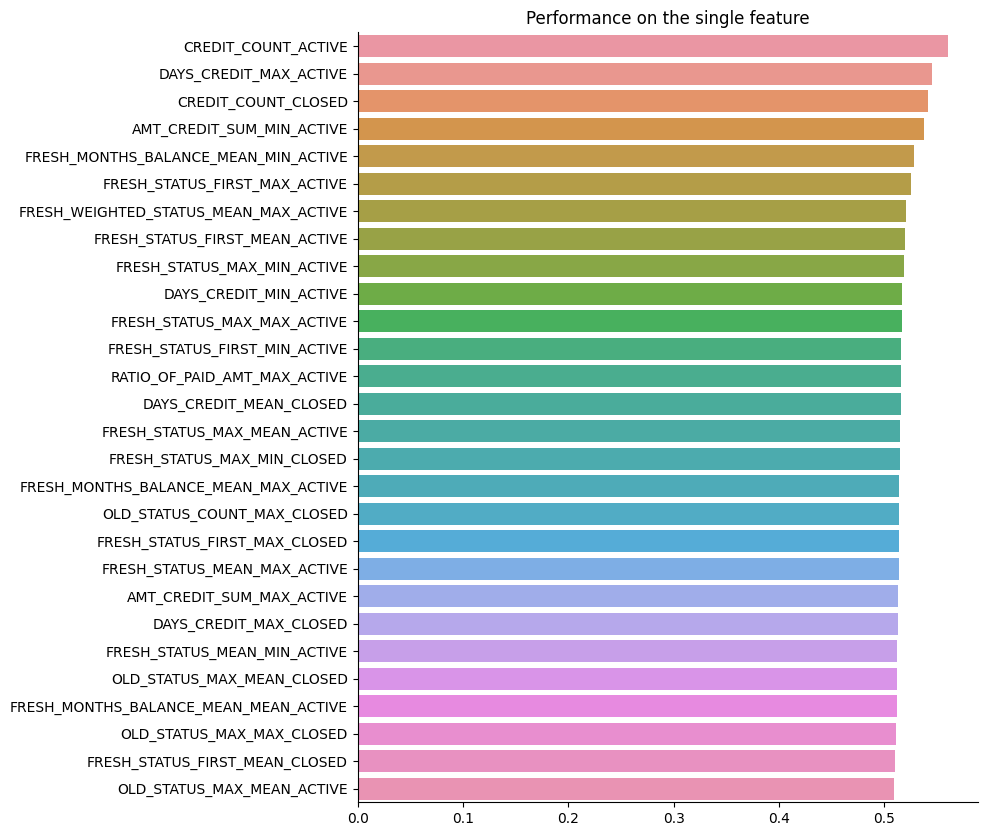

In [68]:
plt.figure(figsize=(8, 10))
sns.barplot(x=important_features.values, y=important_features.index)
plt.title('Performance on the single feature')
sns.despine();

In [21]:
features_to_drop = sfp.features_to_drop_

In [24]:
selected_bureau = merged_bureau.drop(features_to_drop, axis=1)

In [30]:
selected_bureau.to_csv('preprocessed_data/selected_bureau.csv')

In [69]:
# Checking the performance of the model based on the data from credit bureau
model = RandomForestClassifier(max_depth=10, random_state=123, class_weight='balanced')
X = selected_bureau.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = selected_bureau['TARGET']

skf = StratifiedKFold(n_splits=5, shuffle=True)
results = cross_val_score(model, X, y, cv=skf, scoring='roc_auc', n_jobs=4)
print(f'ROC_AUC score for RandomForestClassifier: {round(np.mean(results), 2)}') 

ROC_AUC score for RandomForestClassifier: 0.65


In [7]:
application_train = reduce_memory_usage(pd.read_csv('application_train.csv')).loc[:, ['SK_ID_CURR', 'TARGET']]

## Preprocessing of previous_application.csv

To preprocess previous_application:
* get columns of interest from EDA
* sort values by sk_id_curr and when the process started
* initially clean data based on EDA
* split data and save the sk_id_curr
* preprocess and aggregate categorical features
* select most important categorical features
* preprocess and aggreagate numerical features
* select most important numerical features

### Getting sorted data

In [4]:
# Getting columns of intrest from EDA
columns_of_interest = ['SK_ID_CURR', 'SK_ID_PREV','CNT_PAYMENT', 'HOUR_APPR_PROCESS_START', 'DAYS_DECISION', 
 'SELLERPLACE_AREA', 'DAYS_FIRST_DRAWING', 'DAYS_LAST_DUE_1ST_VERSION',
 'DAYS_FIRST_DUE', 'DAYS_TERMINATION', 'DAYS_LAST_DUE', 'RATE_INTEREST_PRIMARY',
 'PRODUCT_COMBINATION', 'NAME_YIELD_GROUP', 'NAME_CONTRACT_STATUS', 'CODE_REJECT_REASON', 
 'CHANNEL_TYPE', 'NAME_PRODUCT_TYPE', 'NAME_GOODS_CATEGORY', 'NAME_SELLER_INDUSTRY', 'NAME_CASH_LOAN_PURPOSE', 
 'NAME_PORTFOLIO', 'NAME_CONTRACT_TYPE', 'NAME_PAYMENT_TYPE',
 'NAME_CLIENT_TYPE', 'NAME_TYPE_SUITE', 'WEEKDAY_APPR_PROCESS_START', 'FLAG_LAST_APPL_PER_CONTRACT', 'NFLAG_LAST_APPL_IN_DAY']

# Reading in the data
previous = reduce_memory_usage(pd.read_csv('previous_application.csv'))[columns_of_interest]

# Sort values by SK_ID_CURR and days since the decision about last credit
previous = previous.sort_values(by=['SK_ID_CURR', 'DAYS_DECISION'], ascending=True)
previous.head(2)

,SK_ID_CURR,SK_ID_PREV,CNT_PAYMENT,HOUR_APPR_PROCESS_START,DAYS_DECISION,SELLERPLACE_AREA,DAYS_FIRST_DRAWING,DAYS_LAST_DUE_1ST_VERSION,DAYS_FIRST_DUE,DAYS_TERMINATION,DAYS_LAST_DUE,RATE_INTEREST_PRIMARY,PRODUCT_COMBINATION,NAME_YIELD_GROUP,NAME_CONTRACT_STATUS,CODE_REJECT_REASON,CHANNEL_TYPE,NAME_PRODUCT_TYPE,NAME_GOODS_CATEGORY,NAME_SELLER_INDUSTRY,NAME_CASH_LOAN_PURPOSE,NAME_PORTFOLIO,NAME_CONTRACT_TYPE,NAME_PAYMENT_TYPE,NAME_CLIENT_TYPE,NAME_TYPE_SUITE,WEEKDAY_APPR_PROCESS_START,FLAG_LAST_APPL_PER_CONTRACT,NFLAG_LAST_APPL_IN_DAY
201668,100001,1369693,8.00,13,-1740,23,"365,243.00","-1,499.00","-1,709.00","-1,612.00","-1,619.00",NaN,POS mobile with interest,high,Approved,XAP,Country-wide,XNA,Mobile,Connectivity,XAP,POS,Consumer loans,Cash through the bank,Refreshed,Family,FRIDAY,Y,1
892077,100002,1038818,24.00,9,-606,500,"365,243.00",125.00,-565.00,-17.00,-25.00,NaN,POS other with interest,low_normal,Approved,XAP,Stone,XNA,Vehicles,Auto technology,XAP,POS,Consumer loans,XNA,New,NaN,SATURDAY,Y,1


In [5]:
# Removing nonsence values form DAYS_FIRST_DRAWING
previous.loc[previous['DAYS_FIRST_DRAWING'] == 365243] = np.nan

### Getting SK_ID_CURR indices from split

In [6]:
# Getting data with SK_ID_CURR and TARGET variable to perform the split
previous_for_split = application_train.loc[application_train['SK_ID_CURR'].isin(previous['SK_ID_CURR'].unique())]

# Selecting X and y
X = previous_for_split['SK_ID_CURR']
y = previous_for_split['TARGET']

# Splitting data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, train_size=0.4, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, stratify=y_test, train_size=0.5, random_state=42)

# Getting SK_ID_CURR 
previous_id_curr_train = X_train.unique().tolist()
previous_id_curr_val = X_val.unique().tolist()
previous_id_curr_test = X_test.unique().tolist()

### Preprocessing and selecting categorical features

* filling in all missing values with 'XNA'
* reducing cardinality of categorical features based on the training set
* encoding categorical features
* aggregating on sums
* seleting best features 

In [135]:
# Make a list of categorical variables
categorical = [var for var in previous.columns if previous[var].dtype == 'O']

# Filling in missing values
ci = CategoricalImputer(fill_value='XNA', variables=categorical)
previous = ci.fit_transform(previous)

# Performing RareLabelEncoding -> fitting on training data to prevent leakage
rle = RareLabelEncoder(tol=0.04, n_categories=1, variables=categorical)
rle.fit(previous.loc[previous['SK_ID_CURR'].isin(previous_id_curr_train)])
previous = rle.transform(previous)

# Encoding categorical features with OneHotEncoder
ohe = OneHotEncoder()
ohe.fit(previous[categorical + ['SK_ID_CURR']])
encoded_categorical = ohe.transform(previous[categorical + ['SK_ID_CURR']])

# Aggregation of categorical variables
agg_categorical = encoded_categorical.groupby(['SK_ID_CURR']).agg(['sum'])
agg_categorical.columns = [f"{'_'.join(ele).upper().replace(' ', '_')}" for ele in agg_categorical.columns]

# Merging with target variable 
merged_categorical = application_train.merge(agg_categorical, left_on='SK_ID_CURR', right_index=True, how='inner')
merged_categorical.head(2)

,SK_ID_CURR,TARGET,PRODUCT_COMBINATION_RARE_SUM,PRODUCT_COMBINATION_CASH_SUM,PRODUCT_COMBINATION_CARD_STREET_SUM,PRODUCT_COMBINATION_CASH_X-SELL:_LOW_SUM,PRODUCT_COMBINATION_CASH_X-SELL:_MIDDLE_SUM,PRODUCT_COMBINATION_CARD_X-SELL_SUM,PRODUCT_COMBINATION_POS_HOUSEHOLD_WITH_INTEREST_SUM,PRODUCT_COMBINATION_POS_MOBILE_WITH_INTEREST_SUM,NAME_YIELD_GROUP_XNA_SUM,NAME_YIELD_GROUP_HIGH_SUM,NAME_YIELD_GROUP_LOW_NORMAL_SUM,NAME_YIELD_GROUP_MIDDLE_SUM,NAME_YIELD_GROUP_RARE_SUM,NAME_CONTRACT_STATUS_RARE_SUM,NAME_CONTRACT_STATUS_CANCELED_SUM,NAME_CONTRACT_STATUS_APPROVED_SUM,NAME_CONTRACT_STATUS_REFUSED_SUM,CODE_REJECT_REASON_RARE_SUM,CODE_REJECT_REASON_XAP_SUM,CODE_REJECT_REASON_LIMIT_SUM,CODE_REJECT_REASON_HC_SUM,CODE_REJECT_REASON_SCO_SUM,CHANNEL_TYPE_RARE_SUM,CHANNEL_TYPE_CREDIT_AND_CASH_OFFICES_SUM,CHANNEL_TYPE_AP+_(CASH_LOAN)_SUM,CHANNEL_TYPE_CONTACT_CENTER_SUM,CHANNEL_TYPE_STONE_SUM,CHANNEL_TYPE_COUNTRY-WIDE_SUM,NAME_PRODUCT_TYPE_XNA_SUM,NAME_PRODUCT_TYPE_X-SELL_SUM,NAME_PRODUCT_TYPE_WALK-IN_SUM,NAME_GOODS_CATEGORY_XNA_SUM,NAME_GOODS_CATEGORY_RARE_SUM,NAME_GOODS_CATEGORY_MOBILE_SUM,NAME_SELLER_INDUSTRY_XNA_SUM,NAME_SELLER_INDUSTRY_CONSUMER_ELECTRONICS_SUM,NAME_SELLER_INDUSTRY_CONNECTIVITY_SUM,NAME_SELLER_INDUSTRY_RARE_SUM,NAME_CASH_LOAN_PURPOSE_XNA_SUM,NAME_CASH_LOAN_PURPOSE_XAP_SUM,NAME_CASH_LOAN_PURPOSE_RARE_SUM,NAME_PORTFOLIO_XNA_SUM,NAME_PORTFOLIO_CASH_SUM,NAME_PORTFOLIO_CARDS_SUM,NAME_PORTFOLIO_POS_SUM,NAME_PORTFOLIO_RARE_SUM,NAME_CONTRACT_TYPE_RARE_SUM,NAME_CONTRACT_TYPE_CASH_LOANS_SUM,NAME_CONTRACT_TYPE_REVOLVING_LOANS_SUM,NAME_CONTRACT_TYPE_CONSUMER_LOANS_SUM,NAME_PAYMENT_TYPE_XNA_SUM,NAME_PAYMENT_TYPE_CASH_THROUGH_THE_BANK_SUM,NAME_PAYMENT_TYPE_RARE_SUM,NAME_CLIENT_TYPE_RARE_SUM,NAME_CLIENT_TYPE_REPEATER_SUM,NAME_CLIENT_TYPE_REFRESHED_SUM,NAME_TYPE_SUITE_XNA_SUM,NAME_TYPE_SUITE_UNACCOMPANIED_SUM,NAME_TYPE_SUITE_FAMILY_SUM,NAME_TYPE_SUITE_RARE_SUM,WEEKDAY_APPR_PROCESS_START_RARE_SUM,WEEKDAY_APPR_PROCESS_START_FRIDAY_SUM,WEEKDAY_APPR_PROCESS_START_SATURDAY_SUM,WEEKDAY_APPR_PROCESS_START_THURSDAY_SUM,WEEKDAY_APPR_PROCESS_START_WEDNESDAY_SUM,WEEKDAY_APPR_PROCESS_START_TUESDAY_SUM,WEEKDAY_APPR_PROCESS_START_MONDAY_SUM,WEEKDAY_APPR_PROCESS_START_SUNDAY_SUM,FLAG_LAST_APPL_PER_CONTRACT_RARE_SUM,FLAG_LAST_APPL_PER_CONTRACT_Y_SUM
3,100006,0,1,2,1,1,0,0,0,0,3,1,1,0,0,0,3,1,1,0,4,1,0,0,0,5,0,0,0,0,3,2,0,5,0,0,5,0,0,0,4,1,0,3,2,0,0,0,0,4,1,0,3,2,0,0,5,0,4,1,0,0,0,0,1,4,0,0,0,0,0,5
4,100007,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1


Now with selection pipeline we will remove the features of little importance and see which one are important to predictions. All fitting will be done on train set to prevent data leakage.
We will use DropHighPSIFeatures to eliminate the features that have great changes in distribution and then select features on a single features performance.

In [136]:
# Getting training data 
select_important = merged_categorical.loc[merged_categorical['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Creating pipeline for selection
selection_pipe = Pipeline(steps=[
    ('drop_high_psi', DropHighPSIFeatures()),
    ('sfp', SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    threshold=0.52,
                    cv=3))
     ])

# Fitting the pipeline
selection_pipe.fit(X, y)

Pipeline(steps=[('drop_high_psi', DropHighPSIFeatures()),
                ('sfp',
                 SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(random_state=42),
                                                  threshold=0.52))])

In [137]:
# Getting features to drop from the selection pipeline
features_to_drop = selection_pipe.named_steps['drop_high_psi'].features_to_drop_ + selection_pipe.named_steps['sfp'].features_to_drop_ 

# Removing not important features and 'TARGET' from categorical set of features
merged_categorical.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_categorical.shape[1]} features of roc_auc single features performance greater than 0.52')

There are 29 features of roc_auc single features performance greater than 0.52


### Preprocessing and selecting numerical features

* aggregation of numerical features
* selecting important features

In [139]:
# Aggregate numerical features
agg_numerical = previous[numerical].drop('SK_ID_PREV', axis=1).groupby(['SK_ID_CURR']).agg(['min', 'max', 'mean'])
agg_numerical.columns = ['_'.join(ele).upper() for ele in agg_numerical.columns]

# Generate a count of previous credits 
previous_count = previous.groupby(['SK_ID_CURR'])['SK_ID_PREV'].count().to_frame()

# Merge aggregation and count frames
agg_numerical['SK_ID_PREV_COUNT'] = previous_count['SK_ID_PREV']

# Merge with target variable
merged_numerical = application_train.merge(agg_numerical, left_on='SK_ID_CURR', right_index=True)
merged_numerical.head(2)

,SK_ID_CURR,TARGET,CNT_PAYMENT_MIN,CNT_PAYMENT_MAX,CNT_PAYMENT_MEAN,HOUR_APPR_PROCESS_START_MIN,HOUR_APPR_PROCESS_START_MAX,HOUR_APPR_PROCESS_START_MEAN,DAYS_DECISION_MIN,DAYS_DECISION_MAX,DAYS_DECISION_MEAN,SELLERPLACE_AREA_MIN,SELLERPLACE_AREA_MAX,SELLERPLACE_AREA_MEAN,DAYS_FIRST_DRAWING_MIN,DAYS_FIRST_DRAWING_MAX,DAYS_FIRST_DRAWING_MEAN,DAYS_LAST_DUE_1ST_VERSION_MIN,DAYS_LAST_DUE_1ST_VERSION_MAX,DAYS_LAST_DUE_1ST_VERSION_MEAN,DAYS_FIRST_DUE_MIN,DAYS_FIRST_DUE_MAX,DAYS_FIRST_DUE_MEAN,DAYS_TERMINATION_MIN,DAYS_TERMINATION_MAX,DAYS_TERMINATION_MEAN,DAYS_LAST_DUE_MIN,DAYS_LAST_DUE_MAX,DAYS_LAST_DUE_MEAN,RATE_INTEREST_PRIMARY_MIN,RATE_INTEREST_PRIMARY_MAX,RATE_INTEREST_PRIMARY_MEAN,NFLAG_LAST_APPL_IN_DAY_MIN,NFLAG_LAST_APPL_IN_DAY_MAX,NFLAG_LAST_APPL_IN_DAY_MEAN,SK_ID_PREV_COUNT
3,100006,0,18.00,48.00,33.00,12.00,15.00,14.40,-438.00,-181.00,-232.40,-1.00,-1.00,-1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,5
4,100007,0,48.00,48.00,48.00,13.00,13.00,13.00,-867.00,-867.00,-867.00,4.00,4.00,4.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,1.00,1.00,1


In [141]:
# Getting training data 
select_important = merged_numerical.loc[merged_numerical['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Imputing missing values 
X = MeanMedianImputer().fit_transform(X, y)

In [142]:
# Fitting selection pipe
selection_pipe.fit(X, y)

Pipeline(steps=[('drop_high_psi', DropHighPSIFeatures()),
                ('sfp',
                 SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(random_state=42),
                                                  threshold=0.52))])

In [143]:
# Getting features to drop from the selection pipeline
features_to_drop = selection_pipe.named_steps['drop_high_psi'].features_to_drop_ + selection_pipe.named_steps['sfp'].features_to_drop_ 

# Removing not important features and 'TARGET' from categorical set of features
merged_numerical.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_numerical.shape[1]} features of roc_auc single features performance greater than 0.52')

There are 12 features of roc_auc single features performance greater than 0.52


### Saving data with most important features from previous_application.csv

In [171]:
# Merging numerical and categorical data of importance
merged_previous_application = merged_numerical.merge(merged_categorical, on='SK_ID_CURR')

# Saving data
merged_previous_application.to_csv('preprocessed_data/selected_previous_application.csv')

## Preprocessing of POS_CASH_balance.csv

* initial cleaning
* aggregations of numerical features
* aggregations of categorical features
* selecting most important features

### Getting data

In [144]:
pos_cash = reduce_memory_usage(pd.read_csv('POS_CASH_balance.csv'))
pos_cash.head(2)

,SK_ID_PREV,SK_ID_CURR,MONTHS_BALANCE,CNT_INSTALMENT,CNT_INSTALMENT_FUTURE,NAME_CONTRACT_STATUS,SK_DPD,SK_DPD_DEF
0,1803195,182943,-31,48.00,45.00,Active,0,0
1,1715348,367990,-33,36.00,35.00,Active,0,0


### Initial cleaning

In [146]:
# Sorting credits 
pos_cash = pos_cash.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

# Changing sign of months_balance
pos_cash['MONTHS_BALANCE'] = pos_cash['MONTHS_BALANCE'].apply(lambda x: -x)

# Years away from application
pos_cash['YEARS_BALANCE'] = pos_cash['MONTHS_BALANCE'].apply(lambda x: x // 12)



### Aggregations of numerical features

In [147]:
# Data from last 2 years
fresh_pos_cash = pos_cash.loc[pos_cash['YEARS_BALANCE'] <= 2]

# Dictionary for aggregations
aggregations_fresh = {
    'MONTHS_BALANCE': ['min', 'mean'], 
    'CNT_INSTALMENT': ['mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['mean'], 
    'SK_DPD': ['mean', 'sum', 'count'], 
    'SK_DPD_DEF': ['mean', 'sum', 'count']
}

# Aggreagating
fresh_pos_cash = fresh_pos_cash.groupby(['SK_ID_PREV']).agg(aggregations_fresh)
fresh_pos_cash.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_pos_cash.columns]

# Data from over 2 years
old_pos_cash = pos_cash.loc[pos_cash['YEARS_BALANCE'] > 2]

# Dictionary for older aggregations
aggregations_old = {
    'MONTHS_BALANCE': ['max', 'mean'], 
    'CNT_INSTALMENT': ['mean', 'sum'],
    'CNT_INSTALMENT_FUTURE': ['mean'], 
    'SK_DPD': ['mean', 'sum', 'count'], 
    'SK_DPD_DEF': ['mean', 'sum', 'count']
}

# Aggreagating
old_pos_cash = old_pos_cash.groupby(['SK_ID_PREV']).agg(aggregations_old)
old_pos_cash.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_pos_cash.columns]


# Merging fresh and old features
pos_cash_merged = fresh_pos_cash.merge(old_pos_cash, right_index=True, left_index=True, how='outer')
pos_cash_merged.fillna(0, inplace=True)

### Aggregations of categorical feature

In [152]:
# Getting counts of each status for each previous credit 
agg_categorical = pd.crosstab(pos_cash['SK_ID_PREV'], pos_cash['NAME_CONTRACT_STATUS'])

### Merging of aggregated columns

In [155]:
# Getting pairs of current and previous applications 
sk_id_prev_curr = previous[['SK_ID_CURR', 'SK_ID_PREV']]

# Merging numerical, categorical and sk_id_curr
pos_cash_merged = sk_id_prev_curr.merge(pos_cash_merged, on='SK_ID_PREV')
pos_cash_merged = pos_cash_merged.merge(agg_categorical, left_on='SK_ID_PREV', right_index=True)

In [157]:
# Pick at the data
pos_cash_merged.head(2)

,SK_ID_CURR,SK_ID_PREV,FRESH_MONTHS_BALANCE_MIN,FRESH_MONTHS_BALANCE_MEAN,FRESH_CNT_INSTALMENT_MEAN,FRESH_CNT_INSTALMENT_SUM,FRESH_CNT_INSTALMENT_FUTURE_MEAN,FRESH_SK_DPD_MEAN,FRESH_SK_DPD_SUM,FRESH_SK_DPD_COUNT,FRESH_SK_DPD_DEF_MEAN,FRESH_SK_DPD_DEF_SUM,FRESH_SK_DPD_DEF_COUNT,OLD_MONTHS_BALANCE_MAX,OLD_MONTHS_BALANCE_MEAN,OLD_CNT_INSTALMENT_MEAN,OLD_CNT_INSTALMENT_SUM,OLD_CNT_INSTALMENT_FUTURE_MEAN,OLD_SK_DPD_MEAN,OLD_SK_DPD_SUM,OLD_SK_DPD_COUNT,OLD_SK_DPD_DEF_MEAN,OLD_SK_DPD_DEF_SUM,OLD_SK_DPD_DEF_COUNT,Active,Amortized debt,Approved,Canceled,Completed,Demand,Returned to the store,Signed,XNA
0,"100,222.00","2,542,938.00",1.00,10.00,18.00,342.00,9.00,0.00,0.00,19.00,0.00,0.00,19.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,18,0,0,0,1,0,0,0,0
1,"100,761.00","1,206,911.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,42.00,39.50,5.83,35.00,2.50,0.00,0.00,6.00,0.00,0.00,6.00,5,0,0,0,1,0,0,0,0


### Aggregations on features grouped by SK_ID_CURR and merging with target variable

In [166]:
# Aggregating all features on sk_id_curr
aggregations = pos_cash_merged.drop(['SK_ID_PREV'], axis=1).groupby(['SK_ID_CURR']).agg(['sum', 'mean', 'min', 'max'])
aggregations.columns = ['_'.join(ele).upper() for ele in aggregations.columns]

# Merging with target variable
merged_pos_cash = application_train.merge(aggregations, left_on='SK_ID_CURR', right_index=True)

### Selecting important features 

In [162]:
# Getting training data 
select_important = merged_pos_cash.loc[merged_pos_cash['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Fitting selection pipe
selection_pipe.fit(X, y)

Pipeline(steps=[('drop_high_psi', DropHighPSIFeatures()),
                ('sfp',
                 SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(random_state=42),
                                                  threshold=0.52))])

In [167]:
# Getting features to drop from the selection pipeline
features_to_drop = selection_pipe.named_steps['drop_high_psi'].features_to_drop_ + selection_pipe.named_steps['sfp'].features_to_drop_ 

# Removing not important features and 'TARGET' from categorical set of features
merged_pos_cash.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_pos_cash.shape[1]} features of roc_auc single features performance greater than 0.52')

There are 14 features of roc_auc single features performance greater than 0.52


### Saving data with most most important features from POS_CASH_balance.csv

In [168]:
reduce_memory_usage(merged_pos_cash).to_csv('preprocessed_data/pos_cash_selected.csv')

## Preprocessing of credit_card_balance.csv

* initial preprocessing from eda
* creating new features
* aggreagating on fresher and older data
* merging results with SK_ID_CURR
* aggregating on groups SK_ID_CURR
* selecting features

### Getting data

In [19]:
# Reading in the data
ccb = reduce_memory_usage(pd.read_csv('credit_card_balance.csv'))

# Sorting dataframe by previous applications and months_balance
ccb = ccb.sort_values(by=['SK_ID_PREV', 'MONTHS_BALANCE'], ascending=False)

In [20]:
sk_id_prev_curr = ccb[['SK_ID_PREV', 'SK_ID_CURR']]

### Initial cleaning and feature engineering

In [21]:
# Removing too high values in AMT_PAYMENT_CURRENT
ccb['AMT_PAYMENT_CURRENT'].loc[ccb['AMT_PAYMENT_CURRENT'] > 4*10**6] == np.nan

# Creating new features
ccb['BALANCE_LIMIT_RATIO'] = ccb['AMT_BALANCE'] / (ccb['AMT_CREDIT_LIMIT_ACTUAL'] + 0.0001)
ccb['AMT_DRAWING_ALL'] = ccb['AMT_DRAWINGS_ATM_CURRENT'] + ccb['AMT_DRAWINGS_CURRENT'] + ccb[
                                    'AMT_DRAWINGS_OTHER_CURRENT'] + ccb['AMT_DRAWINGS_POS_CURRENT']
ccb['YEARS_BALANCE'] = ccb['MONTHS_BALANCE'] // -12

# Changing sign on months_balance
ccb['MONTHS_BALANCE'] = ccb['MONTHS_BALANCE'].apply(lambda x: -x)

### Aggregating on new and old data on SK_ID_CURR

In [22]:
# Columns of importance from EDA
aggregations_columns = [
    'SK_ID_CURR',
    'MONTHS_BALANCE', 'AMT_BALANCE',
    'AMT_CREDIT_LIMIT_ACTUAL', 'AMT_DRAWINGS_ATM_CURRENT',
    'AMT_DRAWINGS_CURRENT', 'AMT_DRAWINGS_OTHER_CURRENT',
    'AMT_DRAWINGS_POS_CURRENT', 'AMT_INST_MIN_REGULARITY',
    'AMT_PAYMENT_CURRENT', 'AMT_PAYMENT_TOTAL_CURRENT',
    'AMT_RECEIVABLE_PRINCIPAL', 'AMT_RECIVABLE', 'AMT_TOTAL_RECEIVABLE',
    'CNT_DRAWINGS_ATM_CURRENT', 'CNT_DRAWINGS_CURRENT',
    'CNT_DRAWINGS_OTHER_CURRENT', 'CNT_DRAWINGS_POS_CURRENT',
    'CNT_INSTALMENT_MATURE_CUM', 'SK_DPD',
    'SK_DPD_DEF', 'BALANCE_LIMIT_RATIO', 'AMT_DRAWING_ALL',
]

# Aggregating on data from last 2 years
fresh_ccb = ccb.loc[ccb['YEARS_BALANCE'] <= 2]
fresh_ccb = fresh_ccb[aggregations_columns].groupby(['SK_ID_CURR']).agg(['min', 'mean', 'max', 'sum'])
fresh_ccb.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_ccb.columns]

# Aggregating on data from over 2 years
old_ccb = ccb.loc[ccb['YEARS_BALANCE'] > 2]
old_ccb = old_ccb[aggregations_columns].groupby(['SK_ID_CURR']).agg(['min', 'mean', 'max', 'sum'])
old_ccb.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_ccb.columns]

# Merging both and filling in missing values with 0
merged_ccb = fresh_ccb.merge(old_ccb, right_index=True, left_index=True, how='outer').fillna(0)

# Adding column with the count of SK_ID_CURR
count_sk_id_prev = ccb.groupby(['SK_ID_CURR'])['SK_ID_PREV'].count().to_frame()
merged_ccb['PREVIOUS_CREDIT_CARD_COUNT'] = count_sk_id_prev['SK_ID_PREV']

### Merging with target variable 

In [31]:
# Merging with target variable
merged_ccb = application_train.merge(merged_ccb, left_on='SK_ID_CURR', right_index=True)
merged_ccb.head(2)

,SK_ID_CURR,SK_ID_CURR_x,TARGET,SK_ID_CURR_y,FRESH_MONTHS_BALANCE_MEAN,FRESH_MONTHS_BALANCE_MAX,FRESH_MONTHS_BALANCE_SUM,FRESH_AMT_CREDIT_LIMIT_ACTUAL_MIN,FRESH_AMT_CREDIT_LIMIT_ACTUAL_MEAN,FRESH_AMT_CREDIT_LIMIT_ACTUAL_MAX,FRESH_AMT_CREDIT_LIMIT_ACTUAL_SUM,FRESH_AMT_DRAWINGS_ATM_CURRENT_MAX,FRESH_AMT_PAYMENT_CURRENT_MIN,FRESH_CNT_DRAWINGS_ATM_CURRENT_MEAN,FRESH_CNT_DRAWINGS_ATM_CURRENT_MAX,FRESH_CNT_DRAWINGS_ATM_CURRENT_SUM,FRESH_CNT_DRAWINGS_CURRENT_MEAN,FRESH_CNT_DRAWINGS_CURRENT_MAX,FRESH_CNT_DRAWINGS_CURRENT_SUM,FRESH_CNT_DRAWINGS_POS_CURRENT_MEAN,FRESH_CNT_DRAWINGS_POS_CURRENT_MAX,FRESH_CNT_DRAWINGS_POS_CURRENT_SUM,FRESH_CNT_INSTALMENT_MATURE_CUM_MIN,FRESH_CNT_INSTALMENT_MATURE_CUM_MEAN,FRESH_CNT_INSTALMENT_MATURE_CUM_MAX,FRESH_CNT_INSTALMENT_MATURE_CUM_SUM,OLD_MONTHS_BALANCE_MIN,OLD_MONTHS_BALANCE_MEAN,OLD_MONTHS_BALANCE_MAX,OLD_MONTHS_BALANCE_SUM,OLD_AMT_BALANCE_MEAN,OLD_AMT_BALANCE_MAX,OLD_AMT_BALANCE_SUM,OLD_AMT_CREDIT_LIMIT_ACTUAL_MIN,OLD_AMT_CREDIT_LIMIT_ACTUAL_MEAN,OLD_AMT_CREDIT_LIMIT_ACTUAL_MAX,OLD_AMT_CREDIT_LIMIT_ACTUAL_SUM,OLD_AMT_DRAWINGS_ATM_CURRENT_MEAN,OLD_AMT_DRAWINGS_ATM_CURRENT_MAX,OLD_AMT_DRAWINGS_ATM_CURRENT_SUM,OLD_AMT_DRAWINGS_CURRENT_MEAN,OLD_AMT_DRAWINGS_CURRENT_MAX,OLD_AMT_DRAWINGS_CURRENT_SUM,OLD_AMT_INST_MIN_REGULARITY_MEAN,OLD_AMT_INST_MIN_REGULARITY_MAX,OLD_AMT_INST_MIN_REGULARITY_SUM,OLD_AMT_PAYMENT_CURRENT_MEAN,OLD_AMT_PAYMENT_CURRENT_MAX,OLD_AMT_PAYMENT_CURRENT_SUM,OLD_AMT_PAYMENT_TOTAL_CURRENT_MEAN,OLD_AMT_PAYMENT_TOTAL_CURRENT_MAX,OLD_AMT_PAYMENT_TOTAL_CURRENT_SUM,OLD_AMT_RECEIVABLE_PRINCIPAL_MEAN,OLD_AMT_RECEIVABLE_PRINCIPAL_MAX,OLD_AMT_RECEIVABLE_PRINCIPAL_SUM,OLD_AMT_RECIVABLE_MIN,OLD_AMT_RECIVABLE_MEAN,OLD_AMT_RECIVABLE_MAX,OLD_AMT_RECIVABLE_SUM,OLD_AMT_TOTAL_RECEIVABLE_MIN,OLD_AMT_TOTAL_RECEIVABLE_MEAN,OLD_AMT_TOTAL_RECEIVABLE_MAX,OLD_AMT_TOTAL_RECEIVABLE_SUM,OLD_CNT_DRAWINGS_ATM_CURRENT_MAX,OLD_CNT_DRAWINGS_ATM_CURRENT_SUM,OLD_CNT_DRAWINGS_CURRENT_MEAN,OLD_CNT_DRAWINGS_CURRENT_MAX,OLD_CNT_DRAWINGS_CURRENT_SUM,OLD_CNT_INSTALMENT_MATURE_CUM_MIN,OLD_CNT_INSTALMENT_MATURE_CUM_MEAN,OLD_CNT_INSTALMENT_MATURE_CUM_MAX,OLD_SK_DPD_MAX,OLD_SK_DPD_DEF_MAX,OLD_BALANCE_LIMIT_RATIO_MEAN,OLD_BALANCE_LIMIT_RATIO_MAX,OLD_BALANCE_LIMIT_RATIO_SUM,OLD_AMT_DRAWING_ALL_MEAN,OLD_AMT_DRAWING_ALL_MAX,OLD_AMT_DRAWING_ALL_SUM,PREVIOUS_CREDIT_CARD_COUNT
0,100002,100002,1,216093,4.00,7,28,225000,"225,000.00",225000,1575000,"90,000.00",0.00,2.00,5.00,14.00,7.00,23,49,5.00,18.00,35.00,0.00,2.14,5.00,15.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,7
3,100006,100006,0,216098,17.00,32,527,45000,"332,419.35",450000,10305000,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,31


### Selecting important features

In [ ]:
from feature_engine.selection import SmartCorrelatedSelection
# Getting training data 
select_important = merged_ccb.loc[merged_ccb['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Creating pipeline for selection
selection_pipe = Pipeline(steps=[
    ('drop_high_psi', DropHighPSIFeatures()),
    ('sfp', SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    threshold=0.52,
                    cv=3)),
   ('scs', SmartCorrelatedSelection())
     ])
# Fitting selection pipe
selection_pipe.fit(X, y)

In [30]:
# Getting features to drop from the selection pipeline
features_to_drop = (selection_pipe.named_steps['drop_high_psi'].features_to_drop_ 
                    + selection_pipe.named_steps['sfp'].features_to_drop_ )
                    + selected_pipe.named_steps['scs'].features_to_drop_)

# Removing not important features and 'TARGET' from categorical set of features
merged_ccb.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_ccb.shape[1] - 1} features of roc_auc single features performance greater than 0.52')

There are 76 features of roc_auc single features performance greater than 0.52


### Saving data with most important features from POS_CASH_balance.csv

In [19]:
merged_ccb.to_csv('preprocessed_data/credit_card_balance_selected.csv')

In [20]:
del merged_ccb

## Preprocessing of installments_payments.csv

* getting the data
* feature engineering
* aggregating on fresh and old data on groups SK_ID_CURR
* selecting most important features
* saving outcome

### Getting the data

In [7]:
# Read in data
installments = reduce_memory_usage(pd.read_csv('installments_payments.csv'))

# Sorting values 
installments = installments.sort_values(by=['SK_ID_CURR', 'SK_ID_PREV', 'NUM_INSTALMENT_NUMBER'], ascending=True)

In [8]:
sk_id_prev_curr = installments[['SK_ID_CURR', 'SK_ID_PREV']]

### Feature engineering

In [9]:
# Adding features
installments['DIFF_DAYS_PAYMNET'] = installments['DAYS_INSTALMENT'] - installments['DAYS_ENTRY_PAYMENT']
installments['DIFF_AMT_INSTALLMENT'] = installments['AMT_INSTALMENT'] - installments['AMT_PAYMENT']
installments['RATIO_AMT_PAYMENT'] = installments['AMT_INSTALMENT'] / (installments['AMT_INSTALMENT'] + 0.00001)
installments['YEARS_BALANCE'] = installments['DAYS_INSTALMENT'] // -365

### Aggreagating on SK_ID_CURR groups of fresh and old data

In [11]:
# Columns to aggregate
aggregations_columns = ['SK_ID_CURR', 'NUM_INSTALMENT_VERSION',
       'NUM_INSTALMENT_NUMBER', 'DAYS_INSTALMENT', 'DAYS_ENTRY_PAYMENT',
       'AMT_INSTALMENT', 'AMT_PAYMENT', 'DIFF_DAYS_PAYMNET',
       'DIFF_AMT_INSTALLMENT', 'RATIO_AMT_PAYMENT']

# Aggregating data from last 2 years
fresh_installments = installments.loc[installments['YEARS_BALANCE'] <= 2]
fresh_installments = fresh_installments[aggregations_columns].groupby(['SK_ID_CURR']).agg(['mean', 'max', 'sum', 'min'])
fresh_installments.columns = [f"FRESH_{'_'.join(ele).upper()}" for ele in fresh_installments.columns]

# Aggregating data from over 2 years
old_installments = installments.loc[installments['YEARS_BALANCE'] > 2]
old_installments = old_installments[aggregations_columns].groupby(['SK_ID_CURR']).agg(['mean', 'max', 'sum', 'min'])
old_installments.columns = [f"OLD_{'_'.join(ele).upper()}" for ele in old_installments.columns]

# Merging fresh and old data aggregations
merged_installments_payments = fresh_installments.merge(old_installments, right_index=True, left_index=True, how='outer').fillna(0)

# Adding column with the count of SK_ID_CURR
count_sk_id_prev = installments.groupby(['SK_ID_CURR'])['SK_ID_PREV'].count().to_frame()
merged_installments_payments['PREVIOUS_CREDIT_COUNT'] = count_sk_id_prev['SK_ID_PREV']

### Merging with target variable

In [14]:
# Merging with target variable
merged_installments_payments = application_train.merge(merged_installments_payments, left_on='SK_ID_CURR', right_index=True)
merged_installments_payments.head(2)

,SK_ID_CURR,TARGET,FRESH_NUM_INSTALMENT_VERSION_MEAN,FRESH_NUM_INSTALMENT_VERSION_MAX,FRESH_NUM_INSTALMENT_VERSION_SUM,FRESH_NUM_INSTALMENT_VERSION_MIN,FRESH_NUM_INSTALMENT_NUMBER_MEAN,FRESH_NUM_INSTALMENT_NUMBER_MAX,FRESH_NUM_INSTALMENT_NUMBER_SUM,FRESH_NUM_INSTALMENT_NUMBER_MIN,FRESH_DAYS_INSTALMENT_MEAN,FRESH_DAYS_INSTALMENT_MAX,FRESH_DAYS_INSTALMENT_SUM,FRESH_DAYS_INSTALMENT_MIN,FRESH_DAYS_ENTRY_PAYMENT_MEAN,FRESH_DAYS_ENTRY_PAYMENT_MAX,FRESH_DAYS_ENTRY_PAYMENT_SUM,FRESH_DAYS_ENTRY_PAYMENT_MIN,FRESH_AMT_INSTALMENT_MEAN,FRESH_AMT_INSTALMENT_MAX,FRESH_AMT_INSTALMENT_SUM,FRESH_AMT_INSTALMENT_MIN,FRESH_AMT_PAYMENT_MEAN,FRESH_AMT_PAYMENT_MAX,FRESH_AMT_PAYMENT_SUM,FRESH_AMT_PAYMENT_MIN,FRESH_DIFF_DAYS_PAYMNET_MEAN,FRESH_DIFF_DAYS_PAYMNET_MAX,FRESH_DIFF_DAYS_PAYMNET_SUM,FRESH_DIFF_DAYS_PAYMNET_MIN,FRESH_DIFF_AMT_INSTALLMENT_MEAN,FRESH_DIFF_AMT_INSTALLMENT_MAX,FRESH_DIFF_AMT_INSTALLMENT_SUM,FRESH_DIFF_AMT_INSTALLMENT_MIN,FRESH_RATIO_AMT_PAYMENT_MEAN,FRESH_RATIO_AMT_PAYMENT_MAX,FRESH_RATIO_AMT_PAYMENT_SUM,FRESH_RATIO_AMT_PAYMENT_MIN,OLD_NUM_INSTALMENT_VERSION_MEAN,OLD_NUM_INSTALMENT_VERSION_MAX,OLD_NUM_INSTALMENT_VERSION_SUM,OLD_NUM_INSTALMENT_VERSION_MIN,OLD_NUM_INSTALMENT_NUMBER_MEAN,OLD_NUM_INSTALMENT_NUMBER_MAX,OLD_NUM_INSTALMENT_NUMBER_SUM,OLD_NUM_INSTALMENT_NUMBER_MIN,OLD_DAYS_INSTALMENT_MEAN,OLD_DAYS_INSTALMENT_MAX,OLD_DAYS_INSTALMENT_SUM,OLD_DAYS_INSTALMENT_MIN,OLD_DAYS_ENTRY_PAYMENT_MEAN,OLD_DAYS_ENTRY_PAYMENT_MAX,OLD_DAYS_ENTRY_PAYMENT_SUM,OLD_DAYS_ENTRY_PAYMENT_MIN,OLD_AMT_INSTALMENT_MEAN,OLD_AMT_INSTALMENT_MAX,OLD_AMT_INSTALMENT_SUM,OLD_AMT_INSTALMENT_MIN,OLD_AMT_PAYMENT_MEAN,OLD_AMT_PAYMENT_MAX,OLD_AMT_PAYMENT_SUM,OLD_AMT_PAYMENT_MIN,OLD_DIFF_DAYS_PAYMNET_MEAN,OLD_DIFF_DAYS_PAYMNET_MAX,OLD_DIFF_DAYS_PAYMNET_SUM,OLD_DIFF_DAYS_PAYMNET_MIN,OLD_DIFF_AMT_INSTALLMENT_MEAN,OLD_DIFF_AMT_INSTALLMENT_MAX,OLD_DIFF_AMT_INSTALLMENT_SUM,OLD_DIFF_AMT_INSTALLMENT_MIN,OLD_RATIO_AMT_PAYMENT_MEAN,OLD_RATIO_AMT_PAYMENT_MAX,OLD_RATIO_AMT_PAYMENT_SUM,OLD_RATIO_AMT_PAYMENT_MIN,PREVIOUS_CREDIT_COUNT
0,100002,1,1.05,2.00,20.00,1.00,10.00,19.00,190.00,1.00,-295.00,-25.00,"-5,605.00",-565.00,-315.42,-49.00,"-5,993.00",-587.00,"11,559.25","53,093.75","219,625.70","9,251.77","11,559.25","53,093.75","219,625.70","9,251.77",20.42,31.00,388.00,12.00,0.00,0.00,0.00,0.00,1.00,1.00,19.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,19
1,100003,0,1.08,2.00,14.00,1.00,3.77,7.00,49.00,1.00,-670.31,-536.00,"-8,714.00",-797.00,-677.85,-544.00,"-8,812.00",-806.00,"118,314.71","560,835.36","1,538,091.27","64,275.61","118,314.71","560,835.36","1,538,091.27","64,275.61",7.54,14.00,98.00,3.00,0.00,0.00,0.00,0.00,1.00,1.00,13.00,1.00,1.00,1.00,12.00,1.00,6.50,12.00,78.00,1.00,"-2,145.00","-1,980.00","-25,740.00","-2,310.00","-2,151.75","-1,985.00","-25,821.00","-2,324.00","6,731.12","6,737.31","80,773.38","6,662.97","6,731.12","6,737.31","80,773.38","6,662.97",6.75,14.00,81.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,12.00,1.00,25


### Selecting important features

In [16]:
# Getting training data 
select_important = merged_installments_payments.loc[merged_installments_payments['SK_ID_CURR'].isin(previous_id_curr_train)]

# Selecting dependent and independent features
X = select_important.drop(['SK_ID_CURR', 'TARGET'], axis=1)
y = select_important['TARGET']

# Creating pipeline for selection
selection_pipe = Pipeline(steps=[
    ('drop_high_psi', DropHighPSIFeatures()),
    ('sfp', SelectBySingleFeaturePerformance(
                    RandomForestClassifier(random_state=42),
                    threshold=0.52,
                    cv=3))
     ])
# Fitting selection pipe
selection_pipe.fit(X, y)

Pipeline(steps=[('drop_high_psi', DropHighPSIFeatures()),
                ('sfp',
                 SelectBySingleFeaturePerformance(estimator=RandomForestClassifier(random_state=42),
                                                  threshold=0.52))])

In [17]:
# Getting features to drop from the selection pipeline
features_to_drop = selection_pipe.named_steps['drop_high_psi'].features_to_drop_ + selection_pipe.named_steps['sfp'].features_to_drop_ 

# Removing not important features and 'TARGET' from categorical set of features
merged_installments_payments.drop((features_to_drop + ['TARGET']), axis=1, inplace=True)
print(f'There are {merged_installments_payments.shape[1] - 1} features of roc_auc single features performance greater than 0.52')

There are 39 features of roc_auc single features performance greater than 0.52


### Saving data with the most important features from installments_payments.csv

In [18]:
reduce_memory_usage(merged_installments_payments).to_csv('preprocessed_data/installments_payments_selected.csv')

In [4]:
bureau_set = set(bureau['SK_ID_CURR'])

In [5]:
app_set = set(application_train['SK_ID_CURR'])

In [6]:
previous_set = set(previous_application['SK_ID_CURR'])

In [7]:
common_el = bureau_set & previous_set

In [8]:
len(common_el), len(bureau_set), len(app_set)

(291091, 305811, 307511)

In [9]:
len(app_set - previous_set - bureau_set)

2470

In [10]:
len(bureau_set - previous_set)

14720

This notebook will be focused on building dataframes with most important features to model 4 types of clients:
1. Clients without any credit history
2. Clients with credit history from outside sources only
3. Clients with credit history only in home credit group
4. Clients with credit history in home credit group and credit bureau

In [11]:
# Checking sets of unique SK_ID_CURR 
app_set = set(application_train['SK_ID_CURR'])
bureau_set = set(bureau['SK_ID_CURR'])
previous_set = set(previous_application['SK_ID_CURR'])

# Displaying messages on each group of clients
print('-'*100)
print(f'Number of clients without credit history: {len(app_set - bureau_set - previous_set)}')
print(f'Number of clients with credit history only from outside sources: {len((app_set & bureau_set) - previous_set)}')
print(f'Number of clients with credit history only from Home Credit Group: {len((app_set & previous_set) - bureau_set)}')
print(f'Number of clients with credit history in Home Credit Group and Credit Bureau: {len(app_set & previous_set & bureau_set)}')
print('-'*100)

----------------------------------------------------------------------------------------------------
Number of clients without credit history: 2470
Number of clients with credit history only from outside sources: 13984
Number of clients with credit history only from Home Credit Group: 41550
Number of clients with credit history in Home Credit Group and Credit Bureau: 249507
----------------------------------------------------------------------------------------------------


* Majority of applications are already clients to Home Credit Group and have history from outside sources.
* 41.5k applications are of previous Home Credit Group Clients that are loyal to the company.
* The group of clients without any history is the smallest but big enough to make predictions.
* 14k clients apply for Home Credit loan for the first time but they already have history from other sources.

## Clients without any credit history

### Getting data

In [12]:
def dataframe_info_decorator(func):
    """Decorator function to display most important features of the DataFrame"""
    def wrapper(*args, **kwargs):
        df = func(*args, **kwargs)
        print(f"{'-'*50} DataFrame Information {'-'*50}")
        print(f"Features: {df.shape[1]}")
        print(f"Entries: {df.shape[0]}")
        print('-'*123)
        display(df.head(2))
        return df
    return wrapper
from typing import Set

@dataframe_info_decorator
def create_dataframe(df: DataFrame, values: Set, columns: List, col_name: str ='SK_ID_CURR') -> DataFrame:
    """Creates a dataframe with the set of values from chosen column and chosen column names"""
    df = df[columns].loc[df[col_name].isin(values)]
    return df

Before building a dataframe of interest we need to take the values of SK_ID_CURR and columns which were showing promise in EDA. We will be using only columns which were correlated to the target with values over 0.05.

In [14]:
# Indicis of clients without history
no_history = app_set - bureau_set - previous_set

# Columns of interes from EDA
col_interest = ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE',
                 'REGION_RATING_CLIENT_W_CITY', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'DEF_30_CNT_SOCIAL_CIRCLE',
                 'DEF_60_CNT_SOCIAL_CIRCLE', 'OWN_CAR_AGE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI',
                 'EXT_SOURCE_1', 'HOUR_APPR_PROCESS_START', 'CNT_CHILDREN', 'ELEVATORS_MODE',
                 'CNT_FAM_MEMBERS', 'FLOORSMIN_MODE', 'AMT_REQ_CREDIT_BUREAU_QRT', 'ELEVATORS_MEDI',
                 'FLOORSMIN_MEDI', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'ENTRANCES_MEDI', 'FLOORSMAX_AVG',
                 'ENTRANCES_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH',
                 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MODE', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 
                 'YEARS_BEGINEXPLUATATION_MEDI', 'AMT_REQ_CREDIT_BUREAU_MON', 'YEARS_BUILD_AVG',
                 'FLOORSMIN_AVG', 'OBS_60_CNT_SOCIAL_CIRCLE', 'YEARS_BEGINEXPLUATATION_AVG', 'OBS_30_CNT_SOCIAL_CIRCLE',
            'OCCUPATION_TYPE', 'NAME_INCOME_TYPE', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE',
                'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EMP_PHONE', 'ORGANIZATION_TYPE',
                'REG_CITY_NOT_LIVE_CITY', 'FLAG_DOCUMENT_3', 'NAME_FAMILY_STATUS', 'NAME_HOUSING_TYPE',
                'LIVE_CITY_NOT_WORK_CITY', 'NAME_CONTRACT_TYPE', 'FLAG_WORK_PHONE', 'FLAG_DOCUMENT_6',
                'FLAG_PHONE', 'WALLSMATERIAL_MODE', 'FLAG_DOCUMENT_16', 'FLAG_DOCUMENT_13', 'FLAG_DOCUMENT_14', 
                'HOUSETYPE_MODE', 'FLAG_DOCUMENT_8', 'FLAG_DOCUMENT_18', 'NAME_TYPE_SUITE', 'REG_REGION_NOT_WORK_REGION',
                'FONDKAPREMONT_MODE', 'FLAG_DOCUMENT_11', 'FLAG_DOCUMENT_15', 'REG_REGION_NOT_LIVE_REGION', 'FLAG_DOCUMENT_21', 
'DAYS_EMPLOYED', 'TARGET']

In [14]:
# col_interest = application_train.columns.tolist()
# col_interest.remove('SK_ID_CURR')

In [15]:
df_1 = create_dataframe(application_train, no_history, col_interest)

-------------------------------------------------- DataFrame Information --------------------------------------------------
Features: 73
Entries: 2470
---------------------------------------------------------------------------------------------------------------------------


,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,REGION_RATING_CLIENT_W_CITY,AMT_ANNUITY,AMT_INCOME_TOTAL,AMT_CREDIT,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,FLOORSMAX_MODE,FLOORSMAX_MEDI,EXT_SOURCE_1,HOUR_APPR_PROCESS_START,CNT_CHILDREN,ELEVATORS_MODE,CNT_FAM_MEMBERS,FLOORSMIN_MODE,AMT_REQ_CREDIT_BUREAU_QRT,ELEVATORS_MEDI,FLOORSMIN_MEDI,AMT_REQ_CREDIT_BUREAU_YEAR,ENTRANCES_MEDI,FLOORSMAX_AVG,ENTRANCES_MODE,YEARS_BEGINEXPLUATATION_MODE,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,YEARS_BUILD_MODE,ELEVATORS_AVG,YEARS_BUILD_MEDI,YEARS_BEGINEXPLUATATION_MEDI,AMT_REQ_CREDIT_BUREAU_MON,YEARS_BUILD_AVG,FLOORSMIN_AVG,OBS_60_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_AVG,OBS_30_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT,NAME_EDUCATION_TYPE,CODE_GENDER,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,FLAG_WORK_PHONE,FLAG_DOCUMENT_6,FLAG_PHONE,WALLSMATERIAL_MODE,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,HOUSETYPE_MODE,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,NAME_TYPE_SUITE,REG_REGION_NOT_WORK_REGION,FONDKAPREMONT_MODE,FLAG_DOCUMENT_11,FLAG_DOCUMENT_15,REG_REGION_NOT_LIVE_REGION,FLAG_DOCUMENT_21,DAYS_EMPLOYED,TARGET
20,0.11,NaN,0.02,"427,500.00",2,"21,375.00","135,000.00","427,500.00",0.00,0.00,7.00,0.17,0.17,0.57,13,0,0.00,2.00,0.04,NaN,0.00,0.04,NaN,0.14,0.17,0.14,0.98,-18252,-1800,-296.00,0.71,0.00,0.70,0.98,NaN,0.70,0.04,0.00,0.98,0.00,Laborers,Working,2,Secondary / secondary special,M,0,1,Self-employed,0,0,Married,House / apartment,0,Revolving loans,0,0,0,"Stone, brick",0,0,0,block of flats,0,0,Unaccompanied,0,reg oper account,0,0,0,0,-4286,0
120,0.72,NaN,0.03,"675,000.00",2,"33,750.00","157,500.00","675,000.00",0.00,0.00,NaN,0.17,0.17,0.37,9,0,0.00,2.00,0.04,NaN,0.00,0.04,NaN,0.14,0.17,0.14,0.99,-9223,-505,-120.00,0.80,0.00,0.80,0.99,NaN,0.80,0.04,0.00,0.99,0.00,High skill tech staff,Commercial associate,2,Higher education,F,1,1,Business Entity Type 3,1,0,Married,House / apartment,0,Revolving loans,0,0,0,"Stone, brick",0,0,0,block of flats,0,0,Unaccompanied,0,reg oper account,0,0,0,0,-802,0


### Initial cleaning of data based on previous EDA

* checking if any columns have drift in distribution - if so remove them
* assign ordinality to NAME_EDUCATION_TYPE
* reduce the number of features with high cardinality
* replace not known values in gender and encode
* encode FLAG_OWN_CAR, FLAG_OWN_REALTY
* replace columns with negative values
* removing nonsence nu

Checking for high psi columns:

In [16]:
from feature_engine.selection import DropHighPSIFeatures
dhpsi = DropHighPSIFeatures(split_frac=0.5, missing_values='ignore')
dhpsi.fit(df_1)
dhpsi.features_to_drop_

[]

All features are stable. 

In [17]:
def change_sign(value):
    if value < 0:
        return value*(-1)

def y_n_encode(value):
    if value == 'Y':
        return 1
    elif value == 'N':
        return 0

In [18]:
# Assign ordinality to NAME_EDUCATION_TYPE
education = {'Secondary / secondary special': 1,
 'Higher education': 3,
 'Incomplete higher': 2,
 'Lower secondary': 0,
 'Academic degree': 4}
df_1['NAME_EDUCATION_TYPE'] = df_1['NAME_EDUCATION_TYPE'].map(education)

# Reducing the number of cardinality in ORGANIZATION-TYPE 
df_1['ORGANIZATION_TYPE'] = df_1['ORGANIZATION_TYPE'].map(organization_replacer)

# Replacing CODE_GENDER.
df_1['CODE_GENDER'].replace({'XNA': np.nan, 'M': 0, 'F': 1}, inplace=True)

# Change days employed 365.243 to 243
df_1['DAYS_EMPLOYED'] = df_1['DAYS_EMPLOYED'].replace({365243: np.nan})

# Changing sign of negative columns
for col in ['DAYS_BIRTH', 'DAYS_LAST_PHONE_CHANGE', 'DAYS_ID_PUBLISH', 'DAYS_EMPLOYED']:
    df_1[col] = df_1[col].map(change_sign)

# Encode 
#df_1['FLAG_OWN_CAR'] = df_1['FLAG_OWN_CAR'].map(y_n_encode)
#df_1['FLAG_OWN_REALTY'] = df_1['FLAG_OWN_REALTY'].map(y_n_encode)

# Application process
from feature_engine.discretisation import EqualWidthDiscretiser
ewd = EqualWidthDiscretiser(bins=6)
ewd.fit(df_1.HOUR_APPR_PROCESS_START.to_frame())
df_1['HOUR_APPR_PROCESS_START'] = ewd.transform(df_1.HOUR_APPR_PROCESS_START.to_frame())

In [19]:
df_1.head()

,EXT_SOURCE_2,EXT_SOURCE_3,REGION_POPULATION_RELATIVE,AMT_GOODS_PRICE,REGION_RATING_CLIENT_W_CITY,AMT_ANNUITY,AMT_INCOME_TOTAL,AMT_CREDIT,DEF_30_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,OWN_CAR_AGE,FLOORSMAX_MODE,FLOORSMAX_MEDI,EXT_SOURCE_1,HOUR_APPR_PROCESS_START,CNT_CHILDREN,ELEVATORS_MODE,CNT_FAM_MEMBERS,FLOORSMIN_MODE,AMT_REQ_CREDIT_BUREAU_QRT,ELEVATORS_MEDI,FLOORSMIN_MEDI,AMT_REQ_CREDIT_BUREAU_YEAR,ENTRANCES_MEDI,FLOORSMAX_AVG,ENTRANCES_MODE,YEARS_BEGINEXPLUATATION_MODE,DAYS_BIRTH,DAYS_ID_PUBLISH,DAYS_LAST_PHONE_CHANGE,YEARS_BUILD_MODE,ELEVATORS_AVG,YEARS_BUILD_MEDI,YEARS_BEGINEXPLUATATION_MEDI,AMT_REQ_CREDIT_BUREAU_MON,YEARS_BUILD_AVG,FLOORSMIN_AVG,OBS_60_CNT_SOCIAL_CIRCLE,YEARS_BEGINEXPLUATATION_AVG,OBS_30_CNT_SOCIAL_CIRCLE,OCCUPATION_TYPE,NAME_INCOME_TYPE,REGION_RATING_CLIENT,NAME_EDUCATION_TYPE,CODE_GENDER,REG_CITY_NOT_WORK_CITY,FLAG_EMP_PHONE,ORGANIZATION_TYPE,REG_CITY_NOT_LIVE_CITY,FLAG_DOCUMENT_3,NAME_FAMILY_STATUS,NAME_HOUSING_TYPE,LIVE_CITY_NOT_WORK_CITY,NAME_CONTRACT_TYPE,FLAG_WORK_PHONE,FLAG_DOCUMENT_6,FLAG_PHONE,WALLSMATERIAL_MODE,FLAG_DOCUMENT_16,FLAG_DOCUMENT_13,FLAG_DOCUMENT_14,HOUSETYPE_MODE,FLAG_DOCUMENT_8,FLAG_DOCUMENT_18,NAME_TYPE_SUITE,REG_REGION_NOT_WORK_REGION,FONDKAPREMONT_MODE,FLAG_DOCUMENT_11,FLAG_DOCUMENT_15,REG_REGION_NOT_LIVE_REGION,FLAG_DOCUMENT_21,DAYS_EMPLOYED,TARGET
20,0.11,NaN,0.02,"427,500.00",2,"21,375.00","135,000.00","427,500.00",0.00,0.00,7.00,0.17,0.17,0.57,2,0,0.00,2.00,0.04,NaN,0.00,0.04,NaN,0.14,0.17,0.14,0.98,18252,1800,296.00,0.71,0.00,0.70,0.98,NaN,0.70,0.04,0.00,0.98,0.00,Laborers,Working,2,1,0,0,1,Self-employed,0,0,Married,House / apartment,0,Revolving loans,0,0,0,"Stone, brick",0,0,0,block of flats,0,0,Unaccompanied,0,reg oper account,0,0,0,0,"4,286.00",0
120,0.72,NaN,0.03,"675,000.00",2,"33,750.00","157,500.00","675,000.00",0.00,0.00,NaN,0.17,0.17,0.37,1,0,0.00,2.00,0.04,NaN,0.00,0.04,NaN,0.14,0.17,0.14,0.99,9223,505,120.00,0.80,0.00,0.80,0.99,NaN,0.80,0.04,0.00,0.99,0.00,High skill tech staff,Commercial associate,2,3,1,1,1,Business,1,0,Married,House / apartment,0,Revolving loans,0,0,0,"Stone, brick",0,0,0,block of flats,0,0,Unaccompanied,0,reg oper account,0,0,0,0,802.00,0
203,0.43,NaN,0.03,"270,000.00",2,"20,353.50","112,500.00","312,768.00",0.00,0.00,21.00,NaN,NaN,NaN,3,0,NaN,2.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,23187,4265,149.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.00,NaN,2.00,Laborers,Working,2,1,0,1,1,Business,0,0,Married,House / apartment,1,Cash loans,0,0,0,NaN,0,0,0,NaN,1,0,Unaccompanied,0,NaN,0,0,0,0,"1,896.00",0
242,0.52,NaN,0.02,"135,000.00",2,"6,750.00","73,341.00","135,000.00",1.00,1.00,11.00,NaN,NaN,NaN,2,0,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,9157,1822,64.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.00,NaN,1.00,Managers,Commercial associate,2,3,1,0,1,Insurance,0,0,Single / not married,House / apartment,0,Revolving loans,0,0,0,NaN,0,0,0,NaN,0,1,Unaccompanied,0,NaN,0,0,0,0,146.00,1
403,0.43,NaN,0.03,"225,000.00",2,"13,284.00","81,000.00","225,000.00",0.00,0.00,NaN,NaN,NaN,NaN,2,0,NaN,1.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,17935,1453,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,0.00,Laborers,Working,2,1,1,1,1,Trade,1,1,Single / not married,House / apartment,0,Cash loans,0,0,0,NaN,0,0,0,NaN,0,1,Unaccompanied,0,NaN,0,0,0,0,474.00,0


### Splitting data

In [20]:
from sklearn.model_selection import train_test_split
# Get features and target
X = df_1.drop('TARGET', axis=1)
y = df_1['TARGET']

# Split the data into train, val anad test
X_train, X_testing, y_train, y_testing = train_test_split(X, y, test_size=0.3, random_state=123, shuffle=True, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_testing, y_testing, test_size=0.5, random_state=123, shuffle=True, stratify=y_testing)

# Get the data for eda
df_train_merged = pd.merge(X_train, y_train, left_index=True, right_index=True)

### Distribution of target

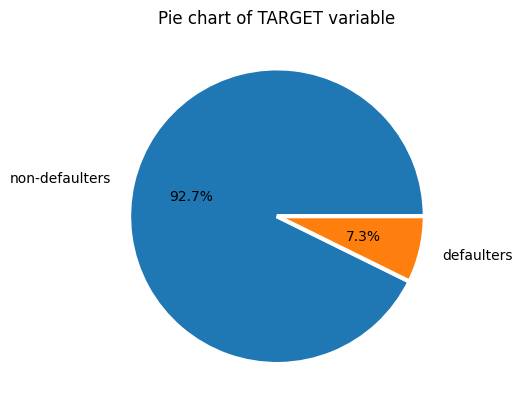

In [21]:
pie_plot(df_train_merged, 'TARGET', ['non-defaulters', 'defaulters'])

Comparing the pie chart with data from full application_train we see that the people without any history default less. 

### Preprocessing

In [22]:
import feature_engine

In [23]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.pipeline import Pipeline as pipe
from sklearn.preprocessing import MinMaxScaler
from feature_engine.encoding import RareLabelEncoder, MeanEncoder
from feature_engine.discretisation import DecisionTreeDiscretiser
from feature_engine.imputation import AddMissingIndicator, MeanMedianImputer, CategoricalImputer
from feature_engine.encoding import WoEEncoder

In [24]:
categorical = [var for var in X_train.columns if X_train[var].dtype == 'O']
# Removing rare columns
from feature_engine.encoding import RareLabelEncoder
rle = RareLabelEncoder(tol=0.04, n_categories=1, variables=categorical, missing_values='ignore')
rle.fit(X_train)
X_train = rle.transform(X_train)
X_val = rle.transform(X_val)
X_test = rle.transform(X_test)

In [25]:
#rle.encoder_dict_

In [26]:
label = 'TARGET'

# make a list of categorical variables
categorical = [var for var in X_train.columns if X_train[var].dtype == 'O']

# make a list of numerical variables
numerical = [var for var in X_train.columns if X_train[var].dtype != 'O']

# make a list of discrete variables
discrete = [ var for var in numerical if len(X_train[var].unique()) < 20]

# categorical encoders work only with object type variables
# to treat numerical variables as categorical, we need to re-cast them
#X_train[discrete]= X_train[discrete].astype('category')

# continuous variables
numerical = [
    var for var in numerical if var not in discrete
    ]


In [27]:
print(f"numerical: {numerical}, \ndiscrete: {discrete}, \ncategorical: {categorical}")

numerical: ['EXT_SOURCE_2', 'EXT_SOURCE_3', 'REGION_POPULATION_RELATIVE', 'AMT_GOODS_PRICE', 'AMT_ANNUITY', 'AMT_INCOME_TOTAL', 'AMT_CREDIT', 'OWN_CAR_AGE', 'FLOORSMAX_MODE', 'FLOORSMAX_MEDI', 'EXT_SOURCE_1', 'ELEVATORS_MODE', 'FLOORSMIN_MODE', 'ELEVATORS_MEDI', 'FLOORSMIN_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_AVG', 'ENTRANCES_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'DAYS_BIRTH', 'DAYS_ID_PUBLISH', 'DAYS_LAST_PHONE_CHANGE', 'YEARS_BUILD_MODE', 'ELEVATORS_AVG', 'YEARS_BUILD_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_AVG', 'FLOORSMIN_AVG', 'YEARS_BEGINEXPLUATATION_AVG', 'DAYS_EMPLOYED'], 
discrete: ['REGION_RATING_CLIENT_W_CITY', 'DEF_30_CNT_SOCIAL_CIRCLE', 'DEF_60_CNT_SOCIAL_CIRCLE', 'HOUR_APPR_PROCESS_START', 'CNT_CHILDREN', 'CNT_FAM_MEMBERS', 'AMT_REQ_CREDIT_BUREAU_QRT', 'AMT_REQ_CREDIT_BUREAU_YEAR', 'AMT_REQ_CREDIT_BUREAU_MON', 'OBS_60_CNT_SOCIAL_CIRCLE', 'OBS_30_CNT_SOCIAL_CIRCLE', 'REGION_RATING_CLIENT', 'NAME_EDUCATION_TYPE', 'CODE_GENDER', 'REG_CITY_NOT_WORK_CITY', 'FLAG_EM

In [28]:
scale_pos_weight = (y_train == 0 ).sum() / (y_train ==1).sum()
round(scale_pos_weight, 2)

12.72

### Preprocessing and feature engineering pipeline

The features will be engineered based on the domain knowladge, eda and the features that turned out to be correlated with the target and research on the topic.

In [29]:
from feature_engine.creation import MathFeatures
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import FunctionTransformer
def mean_knn(x):
    nn_100 = NearestNeighbors(n_neighbors=100)
    df_nn = x[['EXT_SOURCE_1', 'EXT_SOURCE_2','EXT_SOURCE_3', 'AMT_CREDIT', 'AMT_ANNUITY']]
    df_nn['CREDIT_ANNUITY_RATIO'] = x['AMT_CREDIT'] /(x['AMT_ANNUITY'] + 0.0001)
    nn_100.fit(df_nn)        
    train_100_neighbours = nn_100.kneighbors(df_nn)[1] # getting indices of neighbours 
    new_column_1 = [y_train.iloc[ind].mean() for ind in train_100_neighbours]
    
    nn_50 = NearestNeighbors(n_neighbors=50)
    nn_50.fit(df_nn)
    train_50_neighbours = nn_50.kneighbors(df_nn)[1]
    new_column_2 = [y_train.iloc[ind].mean() for ind in train_50_neighbours]
    return np.column_stack((x, new_column_1, new_column_2))

def devision(x):
    return x[0]/(x[1]+0.001)
    
def sum_dev(x):
    return (x[0]+x[1])*x[2]/2
    
def weighted_mul(x):
    return x[0]*2 + x[1]*3 + x[2]*4

def remove_special_chars(s):  # working one
    return ''.join(e if e.isalnum() else '_' for e in s)


preprocess_pipe = Pipeline(steps=[
        # replace NA by the median in the 2 variables below, they are numerical
    ('continuous_var_median_imputer', MeanMedianImputer(
        imputation_method='median', variables=numerical
    )),
    # replace NA in discrete variables by mode value
    ('discreate_var_mode_imputer',CategoricalImputer(imputation_method='frequent',
                                                     ignore_format=True,
                                                    variables=discrete)),

    # replace NA by adding the label "Missing" in categorical variables
    ('categorical_imputer', CategoricalImputer(fill_value='XNA', variables=categorical)),
    
    # encode categorical variables using the target mean
    ('one_hot_encoder', OneHotEncoder(variables=categorical)),
    # ('woeencoder', WoEEncoder(variables=[cat for cat in categorical if cat not in ['NAME_INCOME_TYPE', 'NAME_FAMILY_STATUS', 
    #                                              'EMERGENCYSTATE_MODE']], unseen='ignore', fill_value=0.0001))
    ('nearest_neighbours',  FunctionTransformer(mean_knn)), 
    ('pandarizer', FunctionTransformer(lambda x: pd.DataFrame(x, 
                        columns=preprocess_pipe.named_steps['one_hot_encoder'].get_feature_names_out()+['MEAN_100_KNN', 'MEAN_50_KNN']))),
    ('f_1', MathFeatures(['DAYS_EMPLOYED', 'DAYS_BIRTH'], devision, ['RATIO_EMPLOYED_TO_AGE'])),
    ('f_2', MathFeatures(['AMT_ANNUITY', 'AMT_INCOME_TOTAL'], devision, ['RATIO_ANNUITY_TO_INCOME'])),
    ('f_3', MathFeatures(['REGION_RATING_CLIENT', 'REGION_RATING_CLIENT_W_CITY', 'AMT_INCOME_TOTAL'], sum_dev, ['REGION_TO_INCOME'])),
    ('f_4', MathFeatures(['AMT_INCOME_TOTAL', 'EXT_SOURCE_3'], devision, ['RATIO_INCOME_TO_EXT_SOURCE'])),
    ('f_5', MathFeatures(['AMT_CREDIT', 'EXT_SOURCE_3'], devision, ['RATIO_CREDIT_TO_EXT_SOURCE'])),
    ('f_6', MathFeatures(['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3'], 
                         [np.sum, np.mean, np.max, np.min, np.prod, weighted_mul],
                        ['SUM_EXT_SOURCES', 'MEAN_EXT_SOURCES', 'MAX_EXTERNAL_SOURCES', 'MIN_EXT_SOURCES', 'PROD_EXT_SOURCES', 'WEIGHTED_EXT_SOURCES'])),
    ('f_7', MathFeatures(['AMT_CREDIT', 'AMT_ANNUITY'], devision, ['CREDIT_ANNUITY_RATIO'])),
    ('f_8', MathFeatures(['REGION_POPULATION_RELATIVE', 'AMT_CREDIT'], np.prod, ['PROD_REGION_POPULATION_AMT_CREDIT'])),
    ('f_9', MathFeatures(['REGION_RATING_CLIENT', 'AMT_INCOME_TOTAL'], np.prod, ['PROD_REGION_RATING_AMT_INCOME'])),
    ('f_10', MathFeatures(['AMT_INCOME_TOTAL', 'CNT_CHILDREN'], devision, ['INCOME_PER_CHILD'])),
    ('f_11', MathFeatures(['AMT_INCOME_TOTAL', 'CNT_FAM_MEMBERS'], devision, ['INCOME_PER_PERSON'])),
    ('f_12', MathFeatures(['AMT_ANNUITY', 'AMT_INCOME_TOTAL'], devision, ['ANNUITY_INCOME_PERC'])),
    ('f_13', MathFeatures(['AMT_ANNUITY', 'AMT_CREDIT'], devision, ['PAYMENT_RATE'])),
    ('col_names', FunctionTransformer(lambda x: x.rename(columns=remove_special_chars)))

])

preprocess_pipe.fit(X_train, y_train)
X_train_prep = preprocess_pipe.transform(X_train)
X_val_prep = preprocess_pipe.transform(X_val)
X_test_prep = preprocess_pipe.transform(X_test)

# Concatenate X_train and X_val for cross validation
X_train_val_prep = pd.concat([X_train_prep, X_val_prep])
y_train_val = pd.concat([y_train, y_val])

In [30]:
X_train_prep.shape

(1729, 129)

#### Features selection 

In [198]:
# Features selection based on the model
# initialize feature selector
rfe = RecursiveFeatureElimination(estimator=RandomForestClassifier(max_depth=10), scoring="roc_auc", cv=3)
rfe.fit(X_train_prep.reset_index(drop=True), y_train.reset_index(drop=True))

0.7583930745224455

In [205]:
X_train_selected = rfe.transform(X_train_prep)
X_val_selected = rfe.transform(X_val_prep)
X_train_val_selected = rfe.transform(X_train_val_prep)
X_test_selected = rfe.transform(X_test_prep)

In [200]:
def plot_features_importance(model_name: str, selection=rfe) -> None:
    """Plots 30 most important features based on the selection pipeline.
    Parameters: Pipeline for selecting features, model_name (name of model used for Recursive Feature Elimination)
    Returns: None"""
    important_features = pd.Series(rfe.performance_drifts_).sort_values(ascending=False)[:30].reset_index()
    important_features.columns = ['feature', 'importance']
    plt.figure(figsize=(8, 10))
    sns.barplot(data=important_features, x='importance', y='feature')
    plt.title(f"Importance of Features Selected with {model_name} RecursiveFeatureElimination")
    plt.xlabel("")
    plt.ylabel("")
    plt.yticks(size=7)

----------------------------------------------------------------------------------------------------
Number of selected features: 61
Initial roc_auc: 0.76
----------------------------------------------------------------------------------------------------


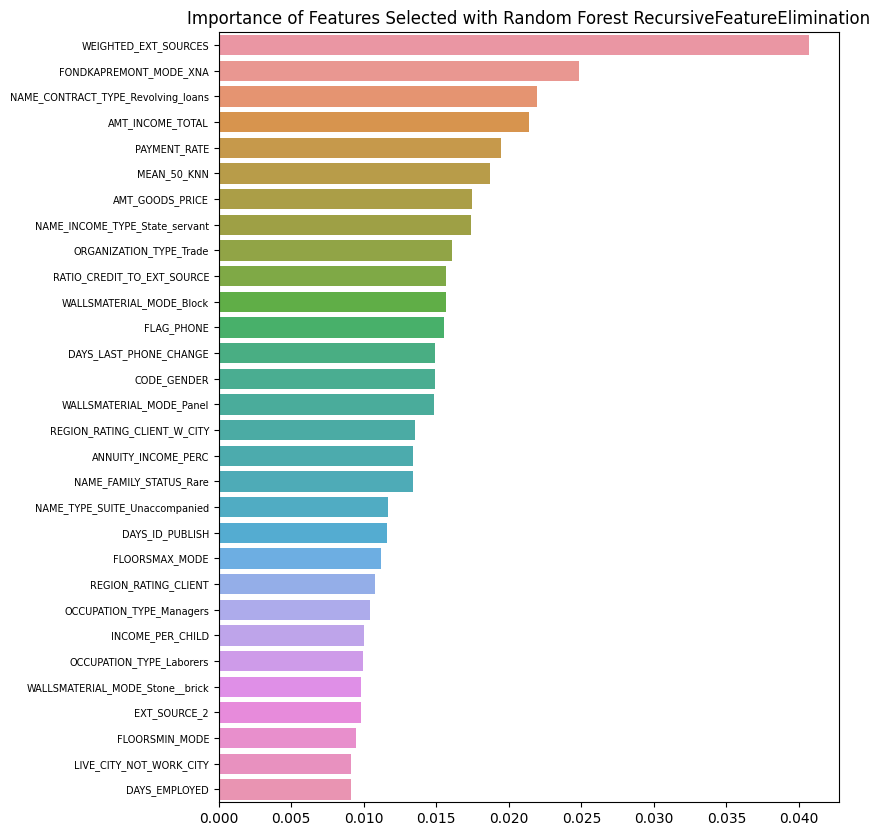

In [201]:
print('-'*100)
print(f'Number of selected features: {X_selected_train.shape[1]}')
print(f'Initial roc_auc: {round(rfe.initial_model_performance_, 2)}')
print('-'*100)
plot_features_importance('Random Forest')

In [3]:
# Aggreagating with target variable
application_train = reduce_memory_usage(pd.read_csv('application_train.csv')).loc[:, ['SK_ID_CURR', 'TARGET']]